# Project Overview: Lead Conversion Prediction

This notebook details a comprehensive machine learning project aimed at predicting lead conversion for X Education. The process involved extensive data preprocessing, training of multiple standalone classification models, and the development of a stacked generalization ensemble to achieve optimal predictive performance.

### 1. Data Loading and Initial Exploration
- Data was loaded from a KaggleHub dataset containing lead information.
- Initial inspection revealed the structure and content of the `Leads.csv` and `Leads Data Dictionary.xlsx` files.
- Duplicate rows were removed to ensure data integrity.

### 2. Data Cleaning and Feature Engineering
- **Column Removal**: Irrelevant and data-leaking columns such as `Prospect ID`, `Lead Number`, `Asymmetrique` features, `Last Activity`, `How did you hear about X Education`, `Search`, `Magazine`, `Newspaper Article`, `X Education Forums`, `Newspaper`, `Digital Advertisement`, `Through Recommendations`, `Receive More Updates About Our Courses`, `Tags`, `Get updates on DM Content`, `Update me on Supply Chain Content`, `Last Notable Activity`, and `I agree to pay the amount through cheque` were dropped.
- **Handling Missing Values**: Strategies were applied to address missing values in critical columns like `TotalVisits`, `Country`, `Specialization`, `What is your current occupation`, `What matters most to you in choosing a course`, `Lead Profile`, and `City`.
- **Categorical Feature Grouping**: Categories within `Lead Origin`, `Lead Source`, `Country`, `City`, `Specialization`, `What is your current occupation`, and `Lead Profile` were grouped or mapped to reduce cardinality and enhance interpretability. For instance, 'Lead Import' data was oversampled to ensure its representation.
- **Numerical Feature Transformation**: `TotalVisits` was binned into 'None', 'Low', 'Medium' categories. `Total Time Spent on Website` and `Page Views Per Visit` were capped at their 90th/99th percentiles respectively to handle outliers.

### 3. Data Preprocessing for Modeling
- **Target Encoding**: Key categorical features (`Lead Origin`, `Lead Source`, `Do Not Email`, `TotalVisits`, `Country`, `Specialization`, `What is your current occupation`, `Lead Profile`, `City`) were target-encoded to convert them into numerical representations while preserving information about the target variable.
- **Feature Scaling**: Continuous numerical features (`Total Time Spent on Website`, `Page Views Per Visit`) were scaled using `StandardScaler`.
- **VIF Analysis**: Variance Inflation Factor (VIF) was checked for continuous variables to ensure multicollinearity was not an issue.

### 4. Standalone Model Training and Evaluation
Four base models were trained and hyperparameter-tuned using `GridSearchCV` with 5-fold cross-validation, optimizing for ROC-AUC:
- **Logistic Regression**: Best parameters: `C=100`, `max_iter=500`, `penalty='l1'`, `solver='saga'`.
- **Random Forest Classifier**: Best parameters: `ccp_alpha=0.0`, `class_weight='balanced_subsample'`, `max_depth=15`, `max_features='sqrt'`, `max_samples=0.8`, `min_samples_leaf=4`, `min_samples_split=2`, `n_estimators=300`.
- **XGBoost Classifier**: Best parameters: `colsample_bytree=0.8`, `gamma=0.2`, `learning_rate=0.01`, `max_depth=7`, `min_child_weight=1`, `n_estimators=200`, `reg_alpha=0`, `subsample=0.8`.
- **Support Vector Classifier (SVC)**: Best parameters: `C=0.8`, `degree=3`, `gamma='scale'`, `kernel='rbf'`, `shrinking=True`.

Each model's performance was rigorously evaluated on a held-out test set, capturing metrics such as Accuracy, Recall, Precision, AUC-ROC, and F1 Score.

### 5. Stacked Generalization
To further improve predictive power, a stacked ensemble approach was implemented:
- **Off-Fold Predictions**: Base models generated out-of-fold predictions on the training data using cross-validation to create the meta-features (`X_meta_train`).
- **Meta-Model Training**: A simple Dense Neural Network (4 input features representing base model predictions -> 128 -> 64 -> 32 -> 16 -> 1 output) was trained on `X_meta_train` and the original `y_train`.
- **Test Set Predictions**: Base models made predictions on the unseen `X_test` to form `X_meta_test`, which was then fed into the trained meta-model to generate final predictions.

### 6. Final Model Evaluation and Insights
- The **Stacked Generalized Dense Neural Network** emerged as the top performer, achieving the highest Accuracy and Precision, along with a strong F1 Score and AUC-ROC on the test set.
- Detailed analysis of individual model strengths (e.g., Random Forest for high recall, XGBoost for high precision) provided insights into their complementary nature, validating the stacking approach.
- Comprehensive recommendations for model deployment and specific business use cases were formulated based on the performance characteristics of each model.

## KaggleHub Data Loading.

In [ ]:
import kagglehub
data_path = kagglehub.dataset_download("ashydv/leads-dataset")

100%|██████████| 436k/436k [00:00<00:00, 32.6MB/s]

Extracting files...


## Import Libariers.

In [ ]:
!pip install category_encoders
!pip install xgboost
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split as TTS, GridSearchCV as GSV, cross_val_predict as CVP

from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
import ast
from openpyxl import Workbook
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC
from tensorflow import random as tf_random
import random

ModuleNotFoundError: No module named 'category_encoders'

## Data Expolaration

### Loading data

In [ ]:
lead_d_path = os.path.join(data_path, "Leads.csv")

### Get to Knowing columns

In [ ]:
column_info_path = os.path.join(data_path,'Leads Data Dictionary.xlsx')
column_info = pd.read_excel(column_info_path)

In [ ]:
dict(zip(column_info['Unnamed: 1'].to_list(), column_info['Unnamed: 2'].to_list()))

{nan: nan,
 'Variables': 'Description',
 'Prospect ID': 'A unique ID with which the customer is identified.',
 'Lead Number': 'A lead number assigned to each lead procured.',
 'Lead Origin': 'The origin identifier with which the customer was identified to be a lead. Includes API, Landing Page Submission, etc.',
 'Lead Source': 'The source of the lead. Includes Google, Organic Search, Olark Chat, etc.',
 'Do Not Email': 'An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.',
 'Do Not Call': 'An indicator variable selected by the customer wherein they select whether of not they want to be called about the course or not.',
 'Converted': 'The target variable. Indicates whether a lead has been successfully converted or not.',
 'TotalVisits': 'The total number of visits made by the customer on the website.',
 'Total Time Spent on Website': 'The total time spent by the customer on the website.',
 'Page Views Per Vis

In [ ]:
column_info

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,NaN,NaN,NaN
1,NaN,Variables,Description
2,NaN,Prospect ID,A unique ID with which the customer is identif...
3,NaN,Lead Number,A lead number assigned to each lead procured.
4,NaN,Lead Origin,The origin identifier with which the customer ...
5,NaN,Lead Source,"The source of the lead. Includes Google, Organ..."
6,NaN,Do Not Email,An indicator variable selected by the customer...
7,NaN,Do Not Call,An indicator variable selected by the customer...
8,NaN,Converted,The target variable. Indicates whether a lead ...
9,NaN,TotalVisits,The total number of visits made by the custome...


### First Inference of OG data.

In [ ]:
lead_data = pd.read_csv(lead_d_path)

In [ ]:
lead_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [ ]:
len(lead_data)

9240

### Removing Duplicate rows
Keeping first


In [ ]:
lead_data.drop_duplicates(keep='first', inplace=True)

### Removing necessary columns

Asymmetrique columns are removed cause we already have

In [ ]:
lead_data.drop(['Prospect ID', 'Lead Number', 'Asymmetrique Activity Index','Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score' ], axis=1, inplace=True)

In [ ]:
lead_data.isnull().sum()

,0
Lead Origin,0
Lead Source,36
Do Not Email,0
Do Not Call,0
Converted,0
TotalVisits,137
Total Time Spent on Website,0
Page Views Per Visit,137
Last Activity,103
Country,2461


In [ ]:
print(f'Total columns: {len(lead_data.columns)}')
val_col_counts = dict(lead_data.isnull().sum())
for prop in val_col_counts:
  if val_col_counts[prop]/len(lead_data) > 0.5:
    lead_data.drop(prop, axis=1, inplace=True)
print(f'Meaningful columns: {len(lead_data.columns)}')

Total columns: 31
Meaningful columns: 30


### Columns Array to Target encode.

In [ ]:
target_encode_cols = []

### Lead Origin

Service the customer uses.

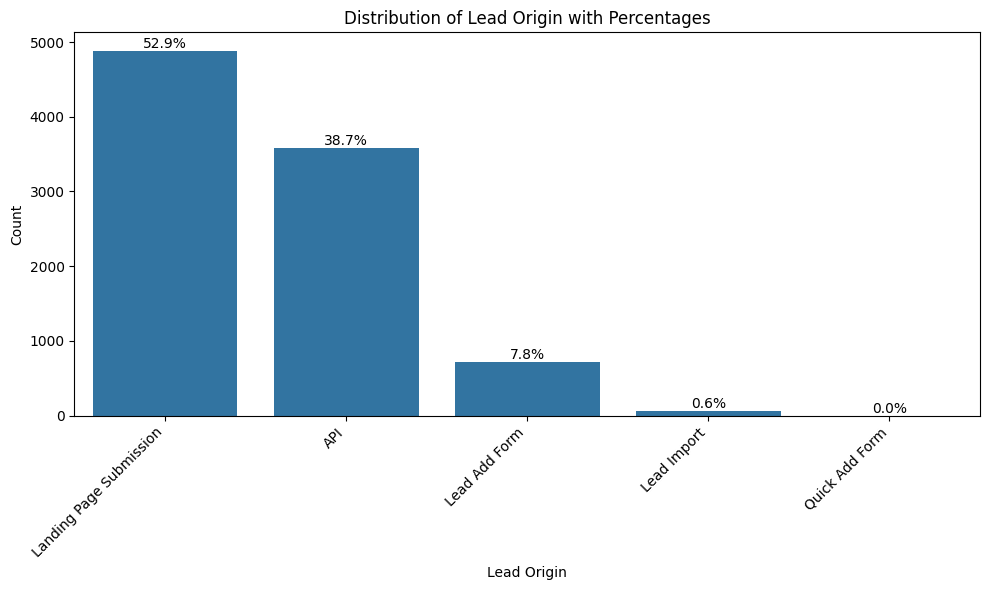

In [ ]:
def lead_origin_count_graph():
  lead_origin_counts = lead_data['Lead Origin'].value_counts()
  lead_origin_percentages = lead_origin_counts / len(lead_data) * 100

  fig, ax = plt.subplots(figsize=(10, 6))
  sns.barplot(x=lead_origin_counts.index, y=lead_origin_counts.values, ax=ax)

  for i, p in enumerate(ax.patches):
      height = p.get_height()
      ax.annotate(f'{lead_origin_percentages.iloc[i]:.1f}%',
                  (p.get_x() + p.get_width() / 2., height),
                  ha='center', va='bottom', fontsize=10, color='black')

  plt.title('Distribution of Lead Origin with Percentages')
  plt.xlabel('Lead Origin')
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

lead_origin_count_graph()

Let us remove the Quick add form and add more row to lead import to make it 1%

In [ ]:
lead_data = lead_data[lead_data['Lead Origin'] != 'Quick Add Form']

Considering the nature of Lead import with target variable.

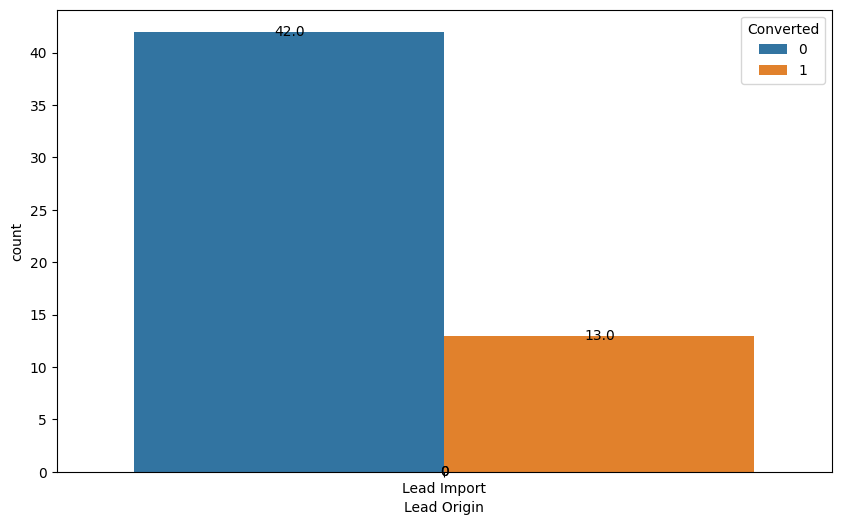

In [ ]:
def lead_import_data_graph(lead_import_data):

  fig,ax = plt.subplots(figsize=(10,6))
  sns.countplot(ax=ax, data=lead_import_data, x='Lead Origin', hue='Converted')

  for p in ax.patches:
      ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=10, color='black')
lead_import_data = lead_data[lead_data['Lead Origin'] == 'Lead Import']
lead_import_data_graph(lead_import_data)


Lead import captures intrinstic pattern forms relationship with the target, so it is necessary to retain.

In [ ]:
def random_over_sampling(data):
  random_over_sampling = RandomOverSampler(random_state=42)
  X = data.drop('Converted', axis=1)
  y = data['Converted']
  X_resampled, y_resampled = random_over_sampling.fit_resample(X, y)
  return pd.concat([X_resampled, y_resampled], axis=1)



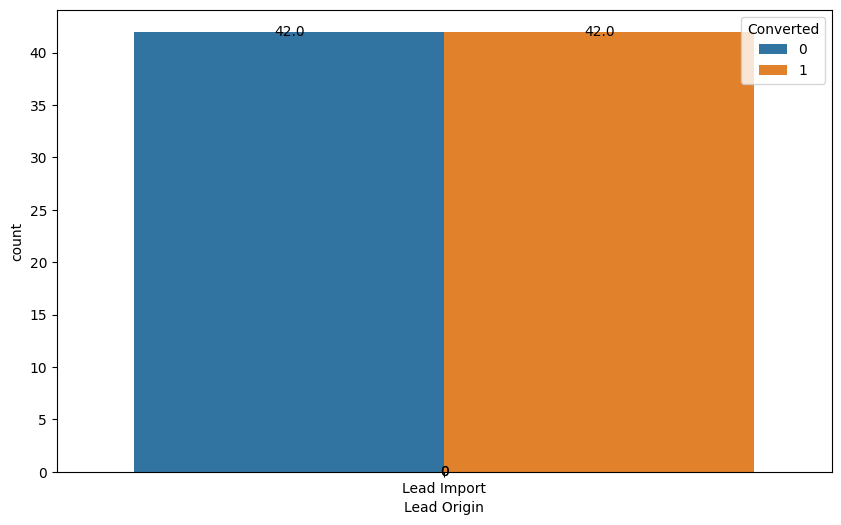

In [ ]:

lead_import_data = random_over_sampling(lead_import_data)
lead_import_data_graph(lead_import_data)

In [ ]:
def duplicate_rows(df,duplicate=10):
  if len(df) < duplicate:
    raise Exception('The df len must be greater than duplicate.')
  for i in range(0, duplicate, 1):
    row_no = np.random.randint(0, len(df))
    new_row_df = df.iloc[[row_no]]
    df = pd.concat([df,new_row_df], ignore_index=True,axis=0)
  return df



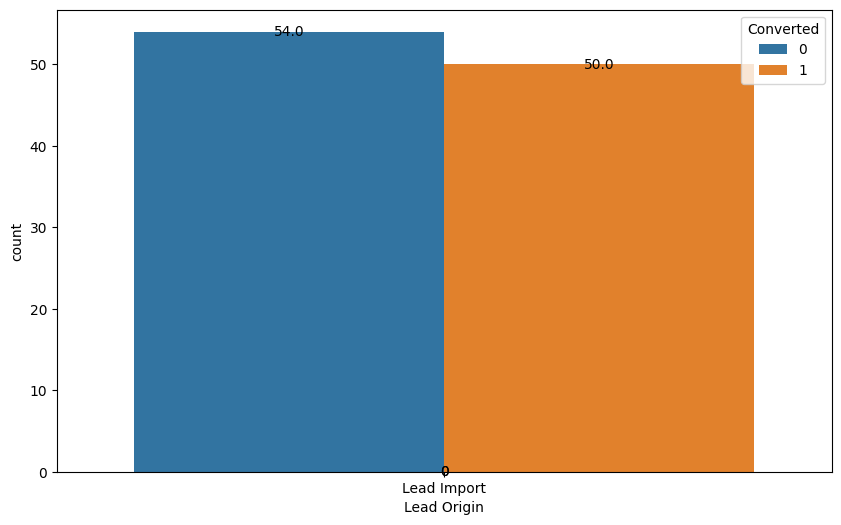

In [ ]:
lead_import_data = duplicate_rows(lead_import_data, 20)
lead_import_data_graph(lead_import_data)

In [ ]:
lead_data = lead_data[lead_data['Lead Origin'] != 'Lead Import']
lead_data = pd.concat([lead_data, lead_import_data], ignore_index=True)


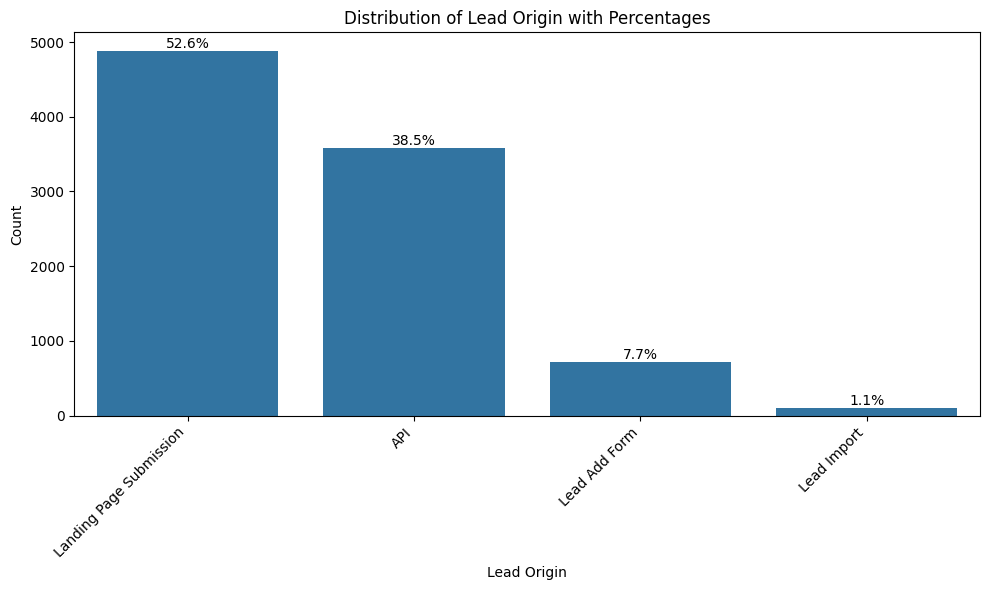

In [ ]:
lead_origin_count_graph()

We improved the lead import to 1.1% to capture its contribution in conversation

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


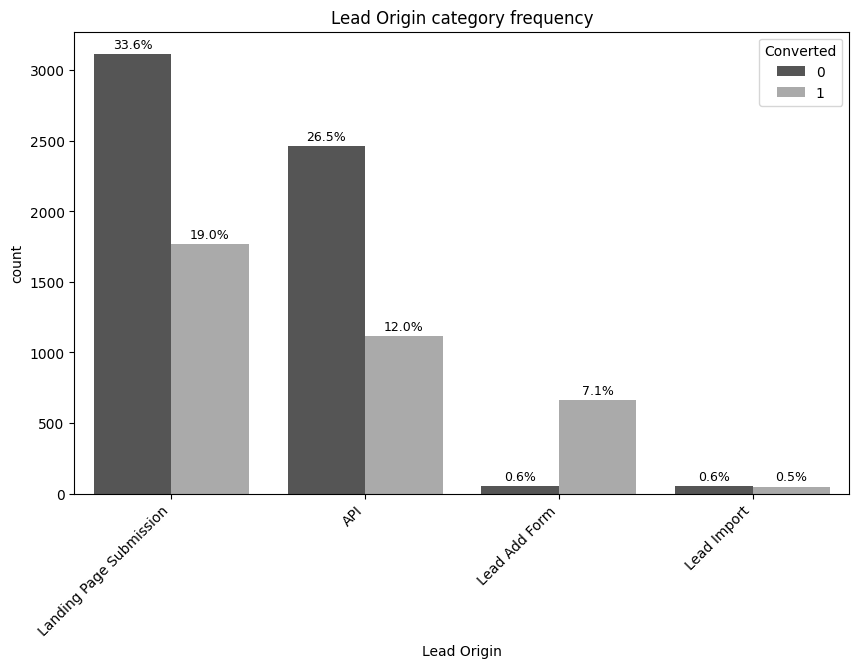

In [ ]:
def cat_graph(column_name, title='', topOffset = 20, min_percentage = 0.0):
  fig,ax = plt.subplots(figsize=(10,6))
  sns.countplot(ax=ax, data=lead_data, x=column_name,hue='Converted', palette='grey', order=lead_data[column_name].value_counts().index)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  total_rows = len(lead_data)
  for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_rows) * 100
    if percentage > min_percentage:
          ax.annotate(
              f'{percentage:.1f}%',
              (p.get_x() + p.get_width() / 2., height + topOffset),
              ha='center',
              va='bottom',
              fontsize=9,
              color='black'
          )
  if title != '':
    plt.title(title)
  plt.dpi = 300
  plt.show()

cat_graph('Lead Origin', 'Lead Origin category frequency')


In [ ]:
lead_data['Lead Origin'].value_counts()

,count
Lead Origin,
Landing Page Submission,4886
API,3580
Lead Add Form,718
Lead Import,104


In [ ]:
 lead_data.isnull().sum()

,0
Lead Origin,0
Lead Source,35
Do Not Email,0
Do Not Call,0
Converted,0
TotalVisits,153
Total Time Spent on Website,0
Page Views Per Visit,153
Last Activity,114
Country,2509


#### Target Encoding.

In [ ]:
target_encode_cols.append('Lead Origin')

### Lead Source

Source in which Lead known about the company

In [ ]:
lead_data['Lead Source'].value_counts()

,count
Lead Source,
Google,2868
Direct Traffic,2543
Olark Chat,1755
Organic Search,1154
Reference,534
Welingak Website,142
Referral Sites,125
Facebook,104
bing,6


In [ ]:
def group_lead_sources(df):

    source_mapping = {

        'Google': 'Paid Advertising',
        'Pay per Click Ads': 'Paid Advertising',

        'Organic Search': 'Organic Search',
        'google': 'Organic Search',
        'bing': 'Organic Search',

        'Direct Traffic': 'Direct Traffic',

        'Olark Chat': 'Chat/Live Support',
        'Live Chat': 'Chat/Live Support',

        'Reference': 'Referral Traffic',
        'Referral Sites': 'Referral Traffic',

        'Facebook': 'Social Media',
        'Social Media': 'Social Media',
        'youtubechannel': 'Social Media',

        'Welingak Website': 'Company camp',
        'blog': 'Company camp',
        'welearnblog_Home': 'Company camp',
        'WeLearn': 'Company camp',

        'Click2call': 'Company camp',
        'Press_Release': 'Company camp',
        'NC_EDM': 'Company camp',
        'testone': 'Company camp',
        np.nan: 'Company camp' #Negligible.
    }

    df['Lead Source Group'] = df['Lead Source'].map(source_mapping)

    return df

lead_data = group_lead_sources(lead_data)

print(lead_data['Lead Source Group'].value_counts())


Lead Source Group
Paid Advertising     2869
Direct Traffic       2543
Chat/Live Support    1757
Organic Search       1165
Referral Traffic      659
Company camp          188
Social Media          107
Name: count, dtype: int64


In [ ]:
lead_data.drop(['Lead Source'],axis=1,inplace=True)

In [ ]:
lead_data.rename(columns={'Lead Source Group': 'Lead Source'}, inplace=True)

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


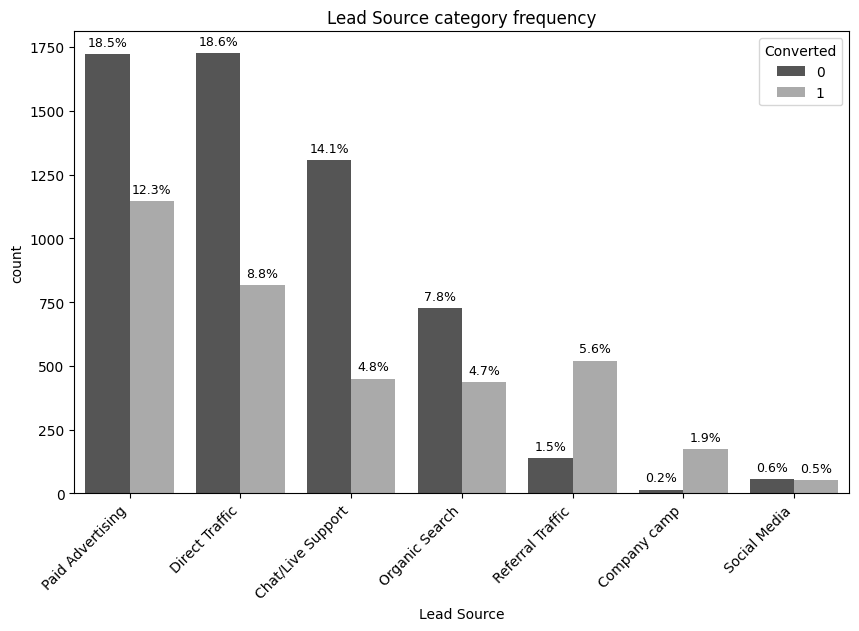

In [ ]:
cat_graph('Lead Source', 'Lead Source category frequency')

In [ ]:
lead_data[lead_data['Lead Source'].isna() == True]

,Lead Origin,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,...,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Lead Source


#### Target Encoding

In [ ]:
target_encode_cols.append('Lead Source')

### Do Not Email

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


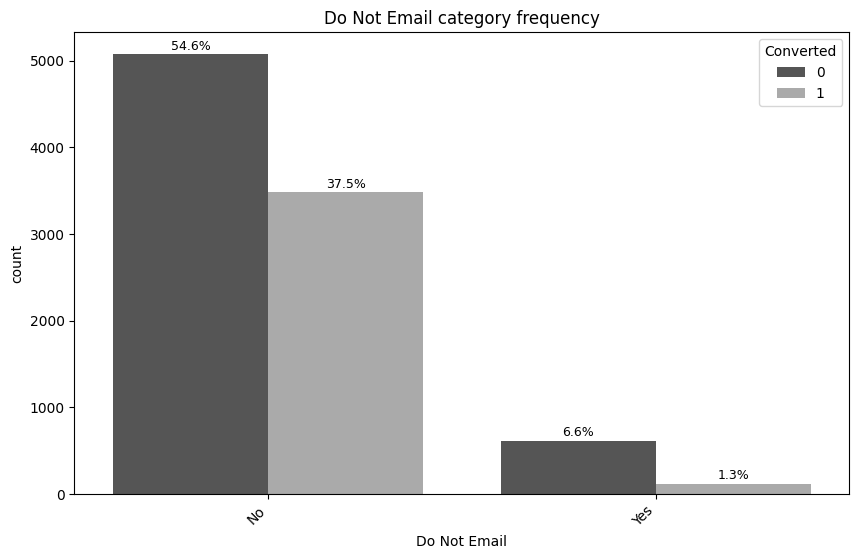

In [ ]:
cat_graph('Do Not Email', 'Do Not Email category frequency')

Nothing extraodinary.

In [ ]:
lead_data[lead_data['Do Not Email'].isna()]

,Lead Origin,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,...,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Lead Source


#### Target Encoding

In [ ]:
target_encode_cols.append('Do Not Email')

### Do Not Call

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


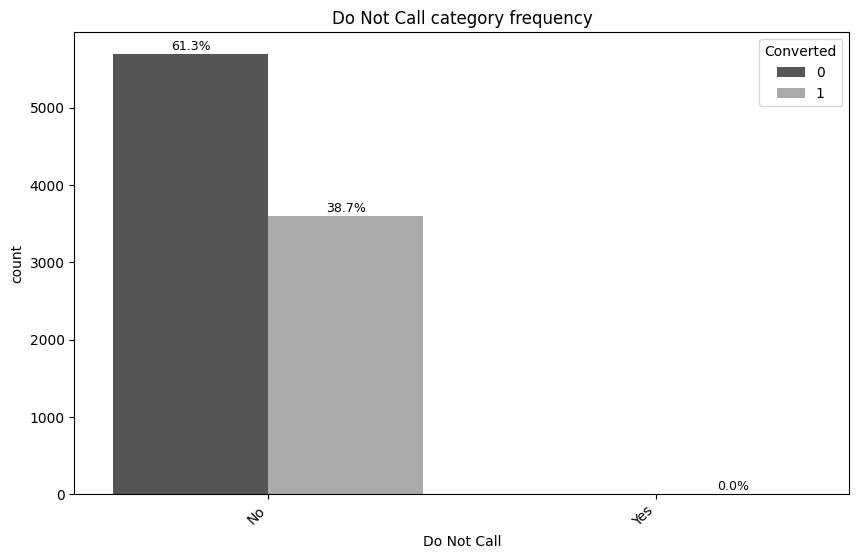

In [ ]:
cat_graph('Do Not Call', 'Do Not Call category frequency')

Data says the donot call button is not easily accessible.

We can remove this column as it does not meaningfully contributing to the Target variable.

In [ ]:
lead_data.drop('Do Not Call', axis=1, inplace=True)

In [ ]:
lead_data.head()

,Lead Origin,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,...,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Lead Source
0,API,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,...,No,Interested in other courses,No,No,Select,Select,No,No,Modified,Chat/Live Support
1,API,No,0,5.0,674,2.5,Email Opened,India,Select,Select,...,No,Ringing,No,No,Select,Select,No,No,Email Opened,Organic Search
2,Landing Page Submission,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,...,No,Will revert after reading the email,No,No,Potential Lead,Mumbai,No,Yes,Email Opened,Direct Traffic
3,Landing Page Submission,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,...,No,Ringing,No,No,Select,Mumbai,No,No,Modified,Direct Traffic
4,Landing Page Submission,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,...,No,Will revert after reading the email,No,No,Select,Mumbai,No,No,Modified,Paid Advertising


### Total Visits

In [ ]:
lead_data['TotalVisits'].value_counts()

,count
TotalVisits,
0.0,2221
2.0,1680
3.0,1306
4.0,1120
5.0,783
6.0,466
1.0,395
7.0,309
8.0,224


Thresholding
Total visits is a **categorical** as it buckets datapoints.

Due to high **cardinality** it is mandatory to solidify based thresholding.

Using 10 based thresholding.

In [ ]:
old_total_visits = dict(lead_data['TotalVisits'].value_counts())

formatted_total_visits = {}
for i in old_total_visits:
  if i == 0:
    formatted_total_visits['None'] = old_total_visits[i]
  elif i < 10:
    formatted_total_visits['Low'] = formatted_total_visits.get('Low', 0) + int(old_total_visits[i])
  elif i < 20:
    formatted_total_visits['Medium'] = formatted_total_visits.get('Medium', 0) + int(old_total_visits[i])
  else:
    formatted_total_visits['High'] = formatted_total_visits.get('High', 0) + int(old_total_visits[i])

print(formatted_total_visits)


{'None': np.int64(2221), 'Low': 6447, 'Medium': 408, 'High': 59}


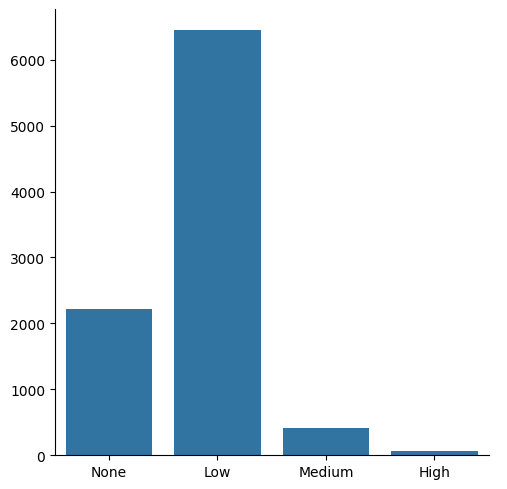

In [ ]:
sns.catplot(x=formatted_total_visits.keys(), y=formatted_total_visits.values(), kind='bar')

Less than 30 is just 0.1% of the data, let us remove the that is below 30 and add 20 - 30 has medium.

In [ ]:
lead_data[lead_data['TotalVisits'].isna()] = 0

In [ ]:
lead_data['TotalVisits'].isna().sum()

np.int64(0)

In [ ]:
def visit_density_category(row):
  if int(row['TotalVisits']) == 0:
    row['TotalVisits'] = 'None'
  elif int(row['TotalVisits']) < 10:
    row['TotalVisits'] = 'Low'
  elif int(row['TotalVisits']) < 30:
    row['TotalVisits'] = 'Medium'
  else:
    row['TotalVisits'] = 'Remove'
  return row

lead_data = lead_data.apply(visit_density_category,axis=1)

lead_data = lead_data[lead_data['TotalVisits'] != 'Remove']


In [ ]:
lead_data['TotalVisits'].value_counts()


,count
TotalVisits,
Low,6447
None,2374
Medium,456


/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


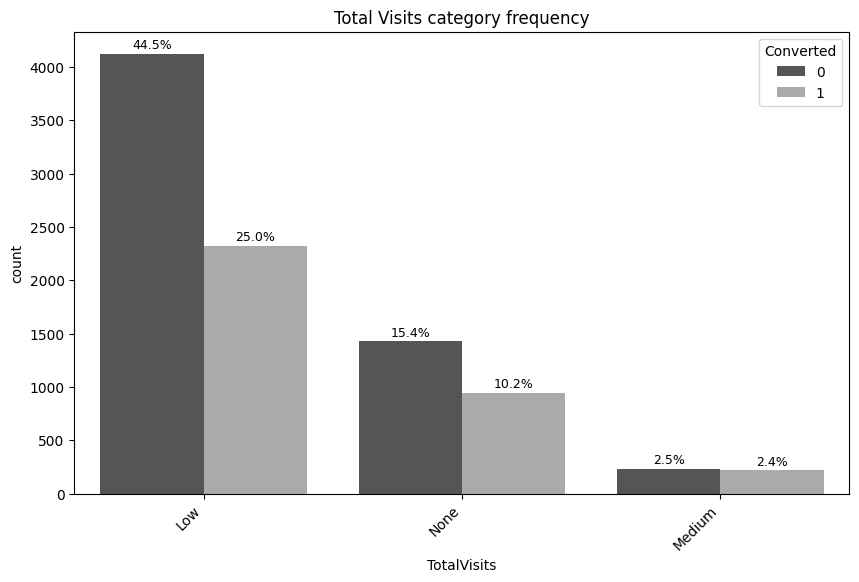

In [ ]:
cat_graph('TotalVisits', 'Total Visits category frequency')

#### Target Encoding

In [ ]:
target_encode_cols.append('TotalVisits')

### Total Time Spent on Website

In [ ]:
lead_data['Total Time Spent on Website'].value_counts()

,count
Total Time Spent on Website,
0,2378
60,19
75,18
127,18
74,17
...,...
617,1
573,1
592,1


Lets treat this continous variable. Cause, If we categorize, the extereme ends of the category misinterpret the model. Other 1s (if thrsholding is 250)1-250 1 and 250 will be treated eqully which is not enterained.

In [ ]:
total_time_max_threshold = lead_data["Total Time Spent on Website"].quantile(0.90)

lead_data['Total Time Spent on Website'] = np.where(lead_data["Total Time Spent on Website"] > total_time_max_threshold, int(total_time_max_threshold), lead_data["Total Time Spent on Website"])


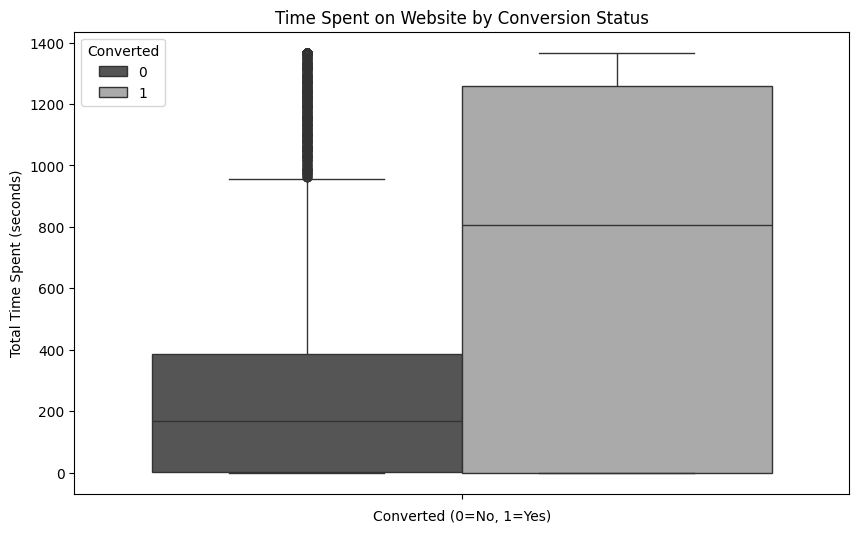

In [ ]:

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=lead_data,
    hue='Converted',
    y='Total Time Spent on Website',
    palette='grey'
)
plt.title('Time Spent on Website by Conversion Status')
plt.xlabel('Converted (0=No, 1=Yes)')
plt.ylabel('Total Time Spent (seconds)')
plt.show()

Shrink is more in 0 category explains 0 page visits likely not converted. It is very useful infromation,

Outliers might explain the tentativeness of the informed clients.

<Axes: xlabel='Total Time Spent on Website', ylabel='Count'>

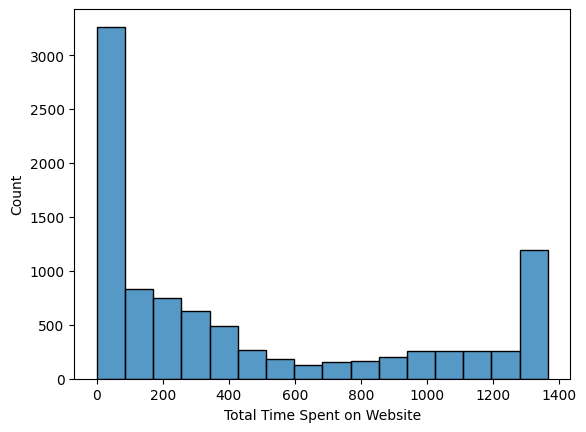

In [ ]:
sns.histplot(lead_data, x='Total Time Spent on Website')

In [ ]:
lead_data["Total Time Spent on Website"].isna().sum()

np.int64(0)

### Page views per visit

In [ ]:
def visualize_cat_cont(colunm_name,title=''):
  plt.figure(figsize=(10, 6))
  sns.boxplot(
      data=lead_data,
      hue='Converted',
      y=colunm_name,
      palette='grey'
  )
  if title != '':
    plt.title(title)
  plt.xlabel('Converted (0=No, 1=Yes)')
  plt.ylabel(colunm_name)
  plt.show()


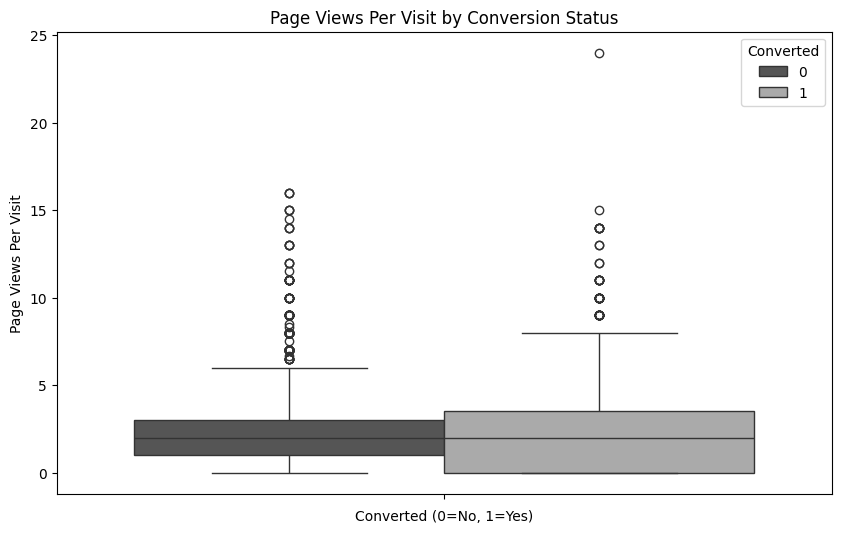

In [ ]:
visualize_cat_cont('Page Views Per Visit', 'Page Views Per Visit by Conversion Status')

In [ ]:
def reassign_exterior_outliers(column_name, quantitle_percentage = 0.95, onlyShowThreshold = True):
  threshold = lead_data[column_name].quantile(quantitle_percentage)
  if onlyShowThreshold:
    print(f'Threshold: {threshold}')
    return
  lead_data[column_name] = np.where(lead_data[column_name] > threshold, threshold, lead_data[column_name])
  return lead_data


resigned_lead_data = reassign_exterior_outliers('Page Views Per Visit', 0.99)


Threshold: 9.0


99% values are less than 9.0, so let us replace anything more than that to 9.

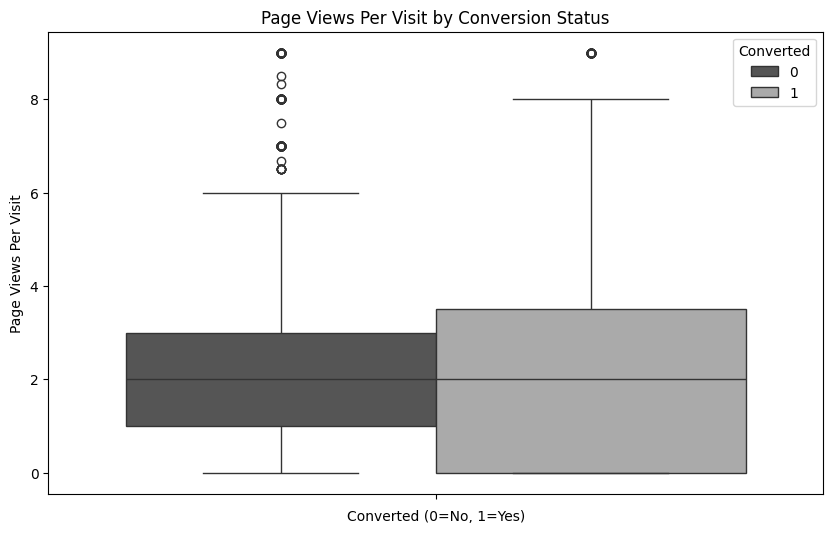

In [ ]:
reassign_exterior_outliers('Page Views Per Visit', 0.99, False)
visualize_cat_cont('Page Views Per Visit', 'Page Views Per Visit by Conversion Status')

In [ ]:
(len(lead_data[lead_data['Page Views Per Visit'] == 9])/ len(lead_data))*100


1.26118357227552

1% of data represents the caped value, let it be, it helps the model capture higher engagement but still not converted pattern.

In [ ]:
lead_data['Page Views Per Visit'].isna().sum()

np.int64(0)

In [ ]:
lead_data.head(5)

,Lead Origin,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,...,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Lead Source
0,API,No,0,None,0,0.0,Page Visited on Website,NaN,Select,Select,...,No,Interested in other courses,No,No,Select,Select,No,No,Modified,Chat/Live Support
1,API,No,0,Low,674,2.5,Email Opened,India,Select,Select,...,No,Ringing,No,No,Select,Select,No,No,Email Opened,Organic Search
2,Landing Page Submission,No,1,Low,1367,2.0,Email Opened,India,Business Administration,Select,...,No,Will revert after reading the email,No,No,Potential Lead,Mumbai,No,Yes,Email Opened,Direct Traffic
3,Landing Page Submission,No,0,Low,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,...,No,Ringing,No,No,Select,Mumbai,No,No,Modified,Direct Traffic
4,Landing Page Submission,No,1,Low,1367,1.0,Converted to Lead,India,Select,Other,...,No,Will revert after reading the email,No,No,Select,Mumbai,No,No,Modified,Paid Advertising


### Last Activity
Last activity did by the customer. Customer here is a potential lead rather than converted (confrimed due the fact there is category Converted to lead.)

In [ ]:
lead_data['Last Activity'].value_counts()

,count
Last Activity,
Email Opened,3456
SMS Sent,2747
Olark Chat Conversation,972
Page Visited on Website,633
Converted to Lead,428
Email Bounced,312
Email Link Clicked,267
0,153
Form Submitted on Website,116


**Includes converted leads - part of target variable itself, so it better remove this column to avoid any complexity.**

In [ ]:
lead_data.drop('Last Activity', axis=1, inplace = True)

In [ ]:
lead_data

,Lead Origin,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,Specialization,How did you hear about X Education,What is your current occupation,...,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Lead Source
0,API,No,0,None,0,0.0,NaN,Select,Select,Unemployed,...,No,Interested in other courses,No,No,Select,Select,No,No,Modified,Chat/Live Support
1,API,No,0,Low,674,2.5,India,Select,Select,Unemployed,...,No,Ringing,No,No,Select,Select,No,No,Email Opened,Organic Search
2,Landing Page Submission,No,1,Low,1367,2.0,India,Business Administration,Select,Student,...,No,Will revert after reading the email,No,No,Potential Lead,Mumbai,No,Yes,Email Opened,Direct Traffic
3,Landing Page Submission,No,0,Low,305,1.0,India,Media and Advertising,Word Of Mouth,Unemployed,...,No,Ringing,No,No,Select,Mumbai,No,No,Modified,Direct Traffic
4,Landing Page Submission,No,1,Low,1367,1.0,India,Select,Other,Unemployed,...,No,Will revert after reading the email,No,No,Select,Mumbai,No,No,Modified,Paid Advertising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,0,0,0,None,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9284,Lead Import,No,1,None,0,0.0,NaN,Select,Select,Unemployed,...,No,NaN,No,No,Select,Other Cities,No,No,SMS Sent,Social Media
9285,Lead Import,No,1,None,0,0.0,NaN,Business Administration,Select,Working Professional,...,No,Will revert after reading the email,No,No,Potential Lead,Mumbai,No,No,Email Opened,Social Media
9286,Lead Import,No,1,None,0,0.0,NaN,Human Resource Management,Select,Working Professional,...,No,Will revert after reading the email,No,No,Potential Lead,Other Cities of Maharashtra,No,No,Email Opened,Social Media


### Country & City

In [ ]:
lead_data['Country'].isnull().sum()

np.int64(2356)

In [ ]:
lead_data['Country'].value_counts()

,count
Country,
India,6481
0,153
United States,69
United Arab Emirates,53
Singapore,24
Saudi Arabia,21
United Kingdom,15
Australia,13
Qatar,10


In [ ]:
lead_data['Country'].unique()

array([nan, 'India', 'Russia', 0, 'Kuwait', 'Oman',
       'United Arab Emirates', 'United States', 'Australia',
       'United Kingdom', 'Bahrain', 'Ghana', 'Singapore', 'Qatar',
       'Saudi Arabia', 'Belgium', 'France', 'Sri Lanka', 'China',
       'Canada', 'Netherlands', 'Sweden', 'Nigeria', 'Hong Kong',
       'Germany', 'Asia/Pacific Region', 'Uganda', 'Kenya', 'Italy',
       'South Africa', 'Tanzania', 'unknown', 'Malaysia', 'Liberia',
       'Switzerland', 'Denmark', 'Philippines', 'Bangladesh', 'Vietnam',
       'Indonesia'], dtype=object)

Most customers happens only in india, so the city maters more than country itself.

But To include country We need to have reasonable number equality of between known countries and known cites

In [ ]:
value_counts_city = lead_data['City'].value_counts()
value_counts_city_df = lead_data['City'].value_counts().reset_index()
value_counts_city_df.columns = ['City', 'Count']

In [ ]:
value_counts_city_df

,City,Count
0,Mumbai,3188
1,Select,2180
2,Thane & Outskirts,742
3,Other Cities,687
4,Other Cities of Maharashtra,457
5,Other Metro Cities,377
6,0,153
7,Tier II Cities,74


In [ ]:
invalid_cities = value_counts_city_df[value_counts_city_df['City'].isin(['Select'])]
invalid_cities['Count'].sum() + lead_data['City'].isna().sum()

np.int64(3599)

In [ ]:
lead_data['City'].isna().sum()

np.int64(1419)

Thane also is within Mumbai, I think this dataset based on company headquartered in / operated from Mumbai. Anyways for country we will have three categories: India, Foreign, Unknown.

City: Maharastera, Others, Unknown.

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


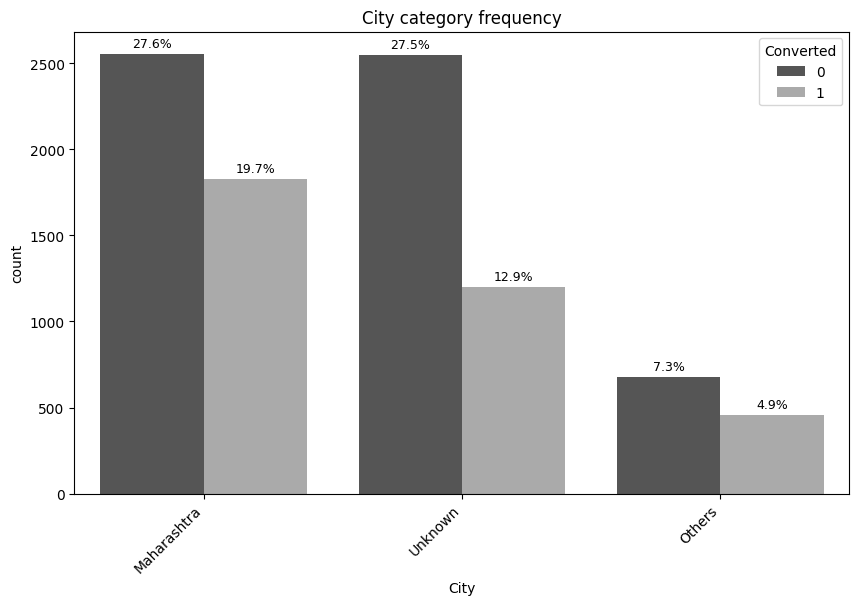

In [ ]:
city_mapping = {
    'Mumbai': 'Maharashtra',
    'Thane & Outskirts': 'Maharashtra',
    'Other Cities of Maharashtra': 'Maharashtra',

    'Other Cities': 'Others',
    'Other Metro Cities': 'Others',
    'Tier II Cities': 'Others',

    'Select': 'Unknown',
    0: 'Unknown',
    '0': 'Unknown',
    np.nan: 'Unknown'
}

lead_data['City'] = lead_data['City'].map(city_mapping)

cat_graph('City', 'City category frequency')

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


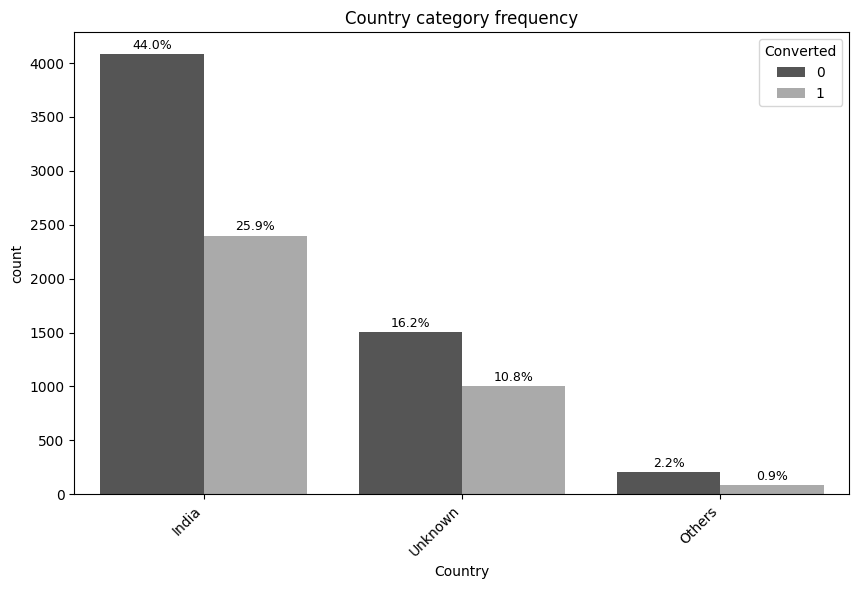

In [ ]:
lead_data.loc[lead_data['Country'] == 0, 'Country'] = "Unknown"

lead_data['Country'] = lead_data['Country'].fillna("Unknown")

lead_data.loc[
    (lead_data['Country'] != 'Unknown') &
    (lead_data['Country'] != 'India'),
    'Country'
] = 'Others'

cat_graph('Country', 'Country category frequency')


#### Target Encoding

In [ ]:
target_encode_cols.append('City')
target_encode_cols.append('Country')

### Specialization

In [ ]:
lead_data['Specialization'].value_counts()

,count
Specialization,
Select,1878
Finance Management,966
Human Resource Management,846
Marketing Management,823
Operations Management,500
Business Administration,404
IT Projects Management,365
Supply Chain Management,345
"Banking, Investment And Insurance",335


In [ ]:
### AI help in grouping.

specialization_groups = {
    # Core Business Functions
    'General Management': ['Business Administration', 'Operations Management'],

    # Finance & Banking
    'Finance & Banking': ['Finance Management', 'Banking, Investment And Insurance'],

    # Marketing & Sales
    'Marketing & Sales': ['Marketing Management', 'Media and Advertising', 'Retail Management', 'International Business'],

    # Technology & Digital
    'Technology & Digital': ['IT Projects Management', 'E-COMMERCE', 'E-Business'],

    # Operations & Supply Chain
    'Operations & Supply Chain': ['Supply Chain Management', 'Hospitality Management',
                                   'Travel and Tourism', 'Rural and Agribusiness'],
    # HR & Services
    'HR & Services': ['Human Resource Management', 'Services Excellence', 'Healthcare Management'],

    'Unknown': ['Select','0', 0]

}


In [ ]:
lead_data['Specialization'].fillna('Unknown', inplace=True)
lead_data['Specialization'] = lead_data['Specialization'].apply(lambda x: next((k for k, v in specialization_groups.items() if x in v), x))

/tmp/ipython-input-3453205431.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lead_data['Specialization'].fillna('Unknown', inplace=True)


/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


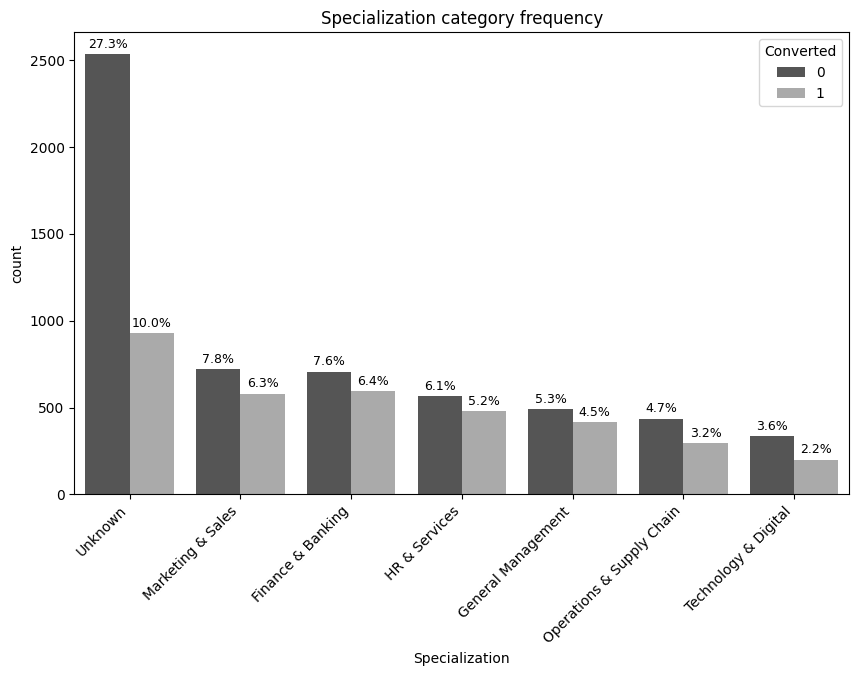

In [ ]:
cat_graph('Specialization', 'Specialization category frequency')

There is decreasing pattern for our yeses, so it is better to TE.

#### Target Encoding

In [ ]:
target_encode_cols.append('Specialization')

In [ ]:
lead_data.head()

,Lead Origin,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,Specialization,How did you hear about X Education,What is your current occupation,...,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Lead Source
0,API,No,0,None,0,0.0,Unknown,Unknown,Select,Unemployed,...,No,Interested in other courses,No,No,Select,Unknown,No,No,Modified,Chat/Live Support
1,API,No,0,Low,674,2.5,India,Unknown,Select,Unemployed,...,No,Ringing,No,No,Select,Unknown,No,No,Email Opened,Organic Search
2,Landing Page Submission,No,1,Low,1367,2.0,India,General Management,Select,Student,...,No,Will revert after reading the email,No,No,Potential Lead,Maharashtra,No,Yes,Email Opened,Direct Traffic
3,Landing Page Submission,No,0,Low,305,1.0,India,Marketing & Sales,Word Of Mouth,Unemployed,...,No,Ringing,No,No,Select,Maharashtra,No,No,Modified,Direct Traffic
4,Landing Page Submission,No,1,Low,1367,1.0,India,Unknown,Other,Unemployed,...,No,Will revert after reading the email,No,No,Select,Maharashtra,No,No,Modified,Paid Advertising


### How did you hear about X Education

In [ ]:
values_count_hear_about = lead_data['How did you hear about X Education'].value_counts().to_frame()

In [ ]:
values_count_hear_about

,count
How did you hear about X Education,
Select,4941
Online Search,806
Word Of Mouth,348
Student of SomeSchool,310
Other,186
0,153
Multiple Sources,152
Advertisements,68
Social Media,66


In [ ]:
(4946+lead_data['How did you hear about X Education'].isna().sum())/len(lead_data)*100
#

np.float64(77.00765333620782)

77% of data is missing it is better to remove the column, other reason to remove this, like we have effective capturer Lead Source.

In [ ]:
lead_data.drop('How did you hear about X Education', axis=1, inplace=True)

### What is your current occupation

In [ ]:
lead_data['What is your current occupation'].value_counts()

,count
What is your current occupation,
Unemployed,5513
Working Professional,691
Student,207
0,153
Other,15
Housewife,9
Businessman,8


In [ ]:
lead_data['What is your current occupation'].isna().sum()

np.int64(2681)

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


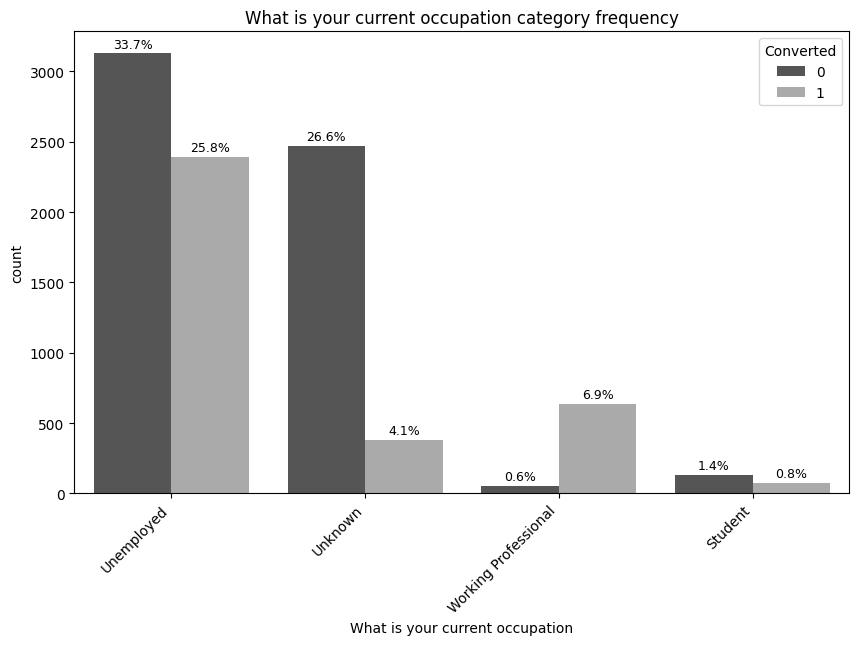

In [ ]:
encoding_map_occupation = {
    'Student': 'Student',
    'Other': 'Unknown',
    'Unemployed': 'Unemployed',
    'Housewife': 'Unemployed',
    0: 'Unknown',
    'Select': 'Unknown',
    'Working Professional': 'Working Professional',
    'Business Owner': 'Working Professional',
    np.nan: 'Unknown'
}


lead_data['What is your current occupation'] = lead_data['What is your current occupation'].map(encoding_map_occupation)

cat_graph('What is your current occupation', 'What is your current occupation category frequency')

It seems like the center is promising empolyment after course completion.

Yes level is uneven so, target encoding.

#### Target Encoding.

In [ ]:
target_encode_cols.append('What is your current occupation')

In [ ]:
lead_data.columns

Index(['Lead Origin', 'Do Not Email', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Country',
       'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Lead Source'],
      dtype='object')

### What matters most to you in choosing this course

In [ ]:
lead_data['What matters most to you in choosing a course'].isna().sum()

np.int64(2699)

In [ ]:
lead_data['What matters most to you in choosing a course'].fillna('Unknown', inplace=True)

/tmp/ipython-input-1022350014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lead_data['What matters most to you in choosing a course'].fillna('Unknown', inplace=True)


In [ ]:
lead_data['What matters most to you in choosing a course'].value_counts()

,count
What matters most to you in choosing a course,
Better Career Prospects,6423
Unknown,2699
0,153
Flexibility & Convenience,1
Other,1


/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


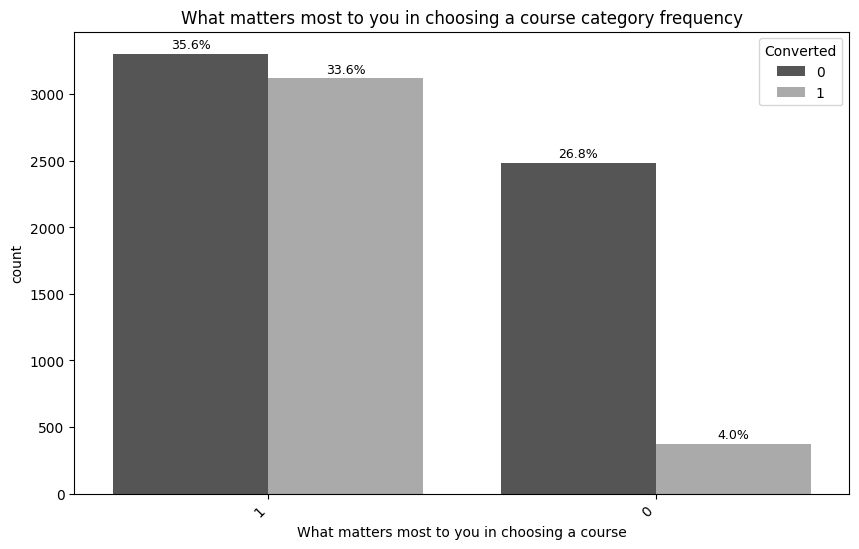

In [ ]:
encoding_map_do_not_email = {
  'Better Career Prospects': 1,
  'Other': 0,
  'Unknown': 0,
  'Flexibility & Convenience': 0,
  0:0,
  '0': 0
}

lead_data['What matters most to you in choosing a course'] = lead_data['What matters most to you in choosing a course'].map(encoding_map_do_not_email)


cat_graph('What matters most to you in choosing a course', 'What matters most to you in choosing a course category frequency')

### Search

In [ ]:
lead_data['Search'].value_counts()

,count
Search,
No,9110
0,153
Yes,14


There is no variance in the column - meaning: it is constant column, Yes|No|Unknown they clearly does not establish relationship with the target variable.

In [ ]:
lead_data.drop('Search', axis=1, inplace=True)

### Magazine

In [ ]:
lead_data['Magazine'].value_counts()

,count
Magazine,
No,9124
0,153


Constant column, so removing.

In [ ]:
lead_data.drop('Magazine', axis=1, inplace=True)

### Newspaper Article

In [ ]:
lead_data['Newspaper Article'].value_counts()

,count
Newspaper Article,
No,9122
0,153
Yes,2


Constant column, so removing.

In [ ]:
lead_data.drop('Newspaper Article', axis=1, inplace=True)

In [ ]:
lead_data.columns

Index(['Lead Origin', 'Do Not Email', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Country',
       'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'X Education Forums',
       'Newspaper', 'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Lead Source'],
      dtype='object')

### X Education Forums

In [ ]:
lead_data['X Education Forums'].value_counts()

,count
X Education Forums,
No,9123
0,153
Yes,1


Constant column, so removing.

In [ ]:
lead_data.drop('X Education Forums', axis=1, inplace=True)

### Newspaper

In [ ]:
lead_data['Newspaper'].value_counts()

,count
Newspaper,
No,9123
0,153
Yes,1


Constant column, so removing.

In [ ]:
lead_data.drop('Newspaper', axis=1, inplace=True)

### Digital Advertisement

In [ ]:
lead_data['Digital Advertisement'].value_counts()

,count
Digital Advertisement,
No,9120
0,153
Yes,4


Constant column, so removing.

In [ ]:
lead_data.drop('Digital Advertisement', axis=1, inplace=True)

### Through Recommendations

In [ ]:
lead_data['Through Recommendations'].value_counts()

,count
Through Recommendations,
No,9117
0,153
Yes,7


Constant column, so removing.

In [ ]:
lead_data.drop('Through Recommendations', axis=1, inplace=True)

### Receive More Updates About Our Courses

In [ ]:
lead_data['Receive More Updates About Our Courses'].value_counts()

,count
Receive More Updates About Our Courses,
No,9124
0,153


Constant column, so removing.

In [ ]:
lead_data.drop('Receive More Updates About Our Courses', axis=1, inplace=True)

### Tags

In [ ]:
lead_data['Tags'].value_counts()

,count
Tags,
Will revert after reading the email,2056
Ringing,1190
Interested in other courses,507
Already a student,465
Closed by Horizzon,301
switched off,240
Busy,185
Lost to EINS,173
0,153


Post converion column

Closed by Horizon" = deal closed (converted)

"Lost to EINS" = lost to competitor (not converted)

"switched off" = not interested (not converted)

"Already a student" = converted
"Not doing further education" = not converted


Strong Data leakage must be droped.

In [ ]:
lead_data.drop('Tags', axis=1, inplace=True)

In [ ]:
lead_data.columns

Index(['Lead Origin', 'Do Not Email', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Country',
       'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity',
       'Lead Source'],
      dtype='object')

### Get updates on DM Content'

In [ ]:
lead_data['Get updates on DM Content'].value_counts()


,count
Get updates on DM Content,
No,9124
0,153


Constant column, so removing.

In [ ]:
lead_data.drop('Get updates on DM Content', axis=1, inplace=True)

### Update me on Supply Chain Content

In [ ]:
lead_data['Update me on Supply Chain Content'].value_counts()

,count
Update me on Supply Chain Content,
No,9124
0,153


Constant column, so removing.

In [ ]:
lead_data.drop('Update me on Supply Chain Content', axis=1, inplace=True)

### Lead Profile

In [ ]:
lead_data.value_counts('Lead Profile')

,count
Lead Profile,
Select,4085
Potential Lead,1578
Other Leads,481
Student of SomeSchool,240
0,153
Lateral Student,21
Dual Specialization Student,20


In [ ]:
(4096+148)/len(lead_data)*100

45.747547698609466

In [ ]:
lead_data.value_counts('Lead Profile').isna().sum()

np.int64(0)

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


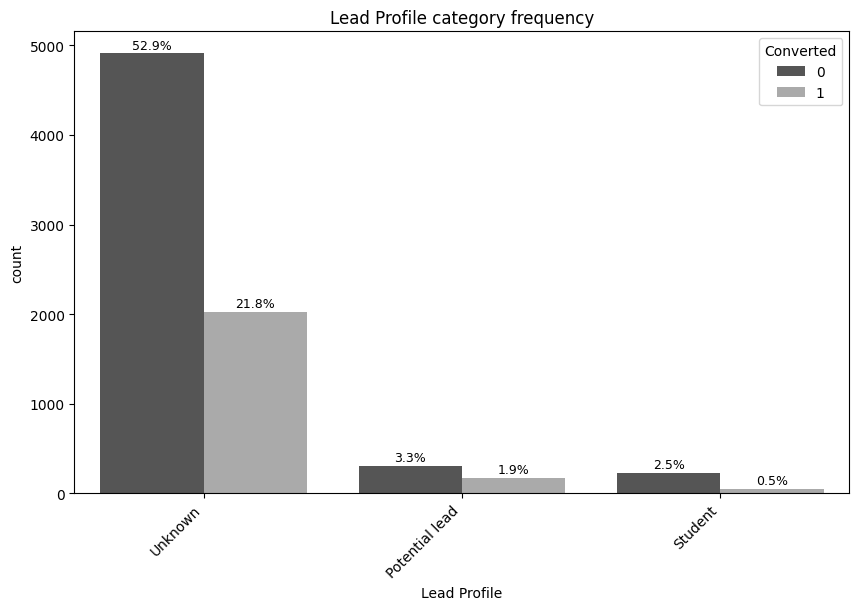

In [ ]:
encoding_map_lead_profile = {
    'Select': 'Unknown',
    0 :'Unknown',
    '0': 'Unknown',
    'Other Leads': 'Potential lead',
    'Student of SomeSchool': 'Student',
    'Lateral Student': 'Student',
    'Dual Specialization Student': 'Student',
    np.nan: 'Unknown'
}

lead_data['Lead Profile'] = lead_data['Lead Profile'].map(encoding_map_lead_profile)

cat_graph('Lead Profile', 'Lead Profile category frequency')

In [ ]:
lead_data['Lead Profile'].unique()

array(['Unknown', nan, 'Potential lead', 'Student'], dtype=object)

In [ ]:
lead_data.loc[lead_data['Lead Profile'].isna(),'Lead Profile'] = 'Unknown'

#### Target Encoding.

In [ ]:
target_encode_cols.append('Lead Profile')

### Last Notable Activity & I agree to pay the amount through cheque

Last Notable Activity - Student Activity

I agree to pay the amount through cheque - Paying amount to convert


Both columns potential for data leakage, removal is necessary.

In [ ]:
lead_data.drop(['Last Notable Activity', 'I agree to pay the amount through cheque'], axis=1, inplace=True)

In [ ]:
lead_data.columns

Index(['Lead Origin', 'Do Not Email', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Country',
       'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Lead Profile', 'City',
       'A free copy of Mastering The Interview', 'Lead Source'],
      dtype='object')

### 'A free copy of Mastering The Interview'

In [ ]:
lead_data['A free copy of Mastering The Interview'].value_counts()

,count
A free copy of Mastering The Interview,
No,6240
Yes,2884
0,153


There is only less amount of Yes, so, let us assign 0 (Insignificant count) to Yes:

In [ ]:
lead_data['A free copy of Mastering The Interview'] = lead_data['A free copy of Mastering The Interview'].replace(0, "Yes")

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


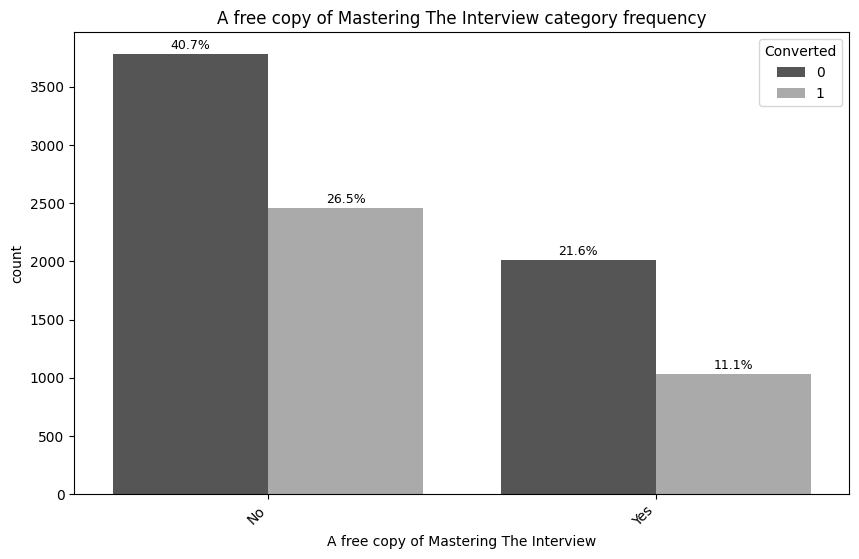

In [ ]:
cat_graph('A free copy of Mastering The Interview', 'A free copy of Mastering The Interview category frequency')

In [ ]:
encoding_map = {
    'No': 0,
    'Yes': 1
}

lead_data['A free copy of Mastering The Interview'] = lead_data['A free copy of Mastering The Interview'].map(encoding_map)

### Target Variable - Converted.

In [ ]:
lead_data['Converted'].isna().sum()

np.int64(0)

/tmp/ipython-input-3536718657.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


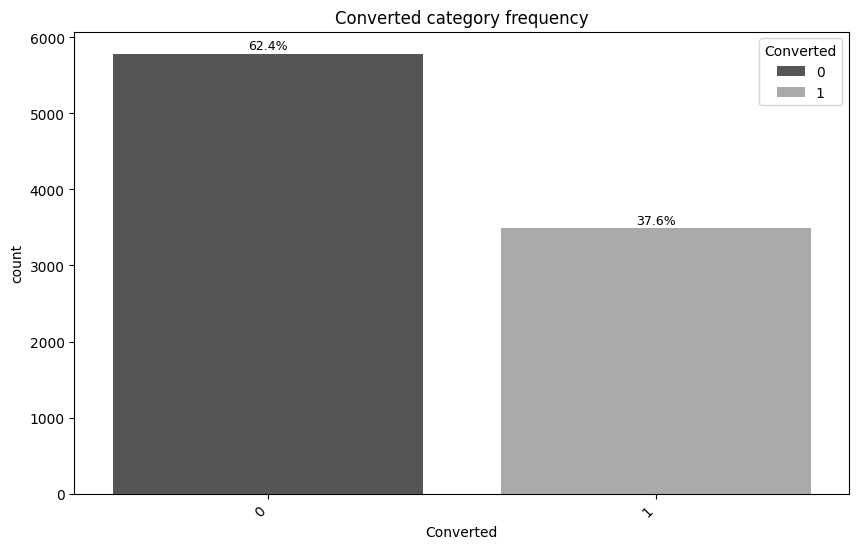

In [ ]:
cat_graph('Converted', 'Converted category frequency')

Does not require smote analysis. SMOTE Only used 95:5, 99:1,
here 60:40, this more suprising for conversion dataset.

In [ ]:
lead_data.head()

,Lead Origin,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Lead Profile,City,A free copy of Mastering The Interview,Lead Source
0,API,No,0,None,0,0.0,Unknown,Unknown,Unemployed,1,Unknown,Unknown,0,Chat/Live Support
1,API,No,0,Low,674,2.5,India,Unknown,Unemployed,1,Unknown,Unknown,0,Organic Search
2,Landing Page Submission,No,1,Low,1367,2.0,India,General Management,Student,1,Unknown,Maharashtra,1,Direct Traffic
3,Landing Page Submission,No,0,Low,305,1.0,India,Marketing & Sales,Unemployed,1,Unknown,Maharashtra,0,Direct Traffic
4,Landing Page Submission,No,1,Low,1367,1.0,India,Unknown,Unemployed,1,Unknown,Maharashtra,0,Paid Advertising


### VIF Factor Analysis - For continous variables

In [ ]:
continuous_cols = lead_data[['Total Time Spent on Website', 'Page Views Per Visit']]

In [ ]:
for i in continuous_cols:
  print(lead_data[i].dtype)

int64
float64


In [ ]:
lead_data['Total Time Spent on Website'] = lead_data['Total Time Spent on Website'].astype(float)
lead_data['Page Views Per Visit'] = lead_data['Page Views Per Visit'].astype(float)

In [ ]:
lead_data['Total Time Spent on Website'].isnull().sum(),lead_data['Page Views Per Visit'].isnull().sum()

(np.int64(0), np.int64(0))

In [ ]:


continuous_cols = ['Total Time Spent on Website', 'Page Views Per Visit']
X_continuous = lead_data[continuous_cols]

vif_data = pd.DataFrame()
vif_data['Feature'] = continuous_cols
vif_data['VIF'] = [variance_inflation_factor(X_continuous.values, i)
                   for i in range(len(continuous_cols))]

print(vif_data)

                       Feature       VIF
0  Total Time Spent on Website  1.887151
1         Page Views Per Visit  1.887151


Both are independent to each other.

### Final Metrics on Exploration

In [ ]:
lead_data.shape

(9277, 14)

In [ ]:
lead_data.isna().sum()

,0
Lead Origin,0
Do Not Email,0
Converted,0
TotalVisits,0
Total Time Spent on Website,0
Page Views Per Visit,0
Country,0
Specialization,0
What is your current occupation,8
What matters most to you in choosing a course,0


In [ ]:
lead_data.to_csv('cleaned_data_without_encoding.csv')

## Data Creation for fine tuning.

In [ ]:
lead_data_dup = pd.read_csv('cleaned_data_without_encoding.csv')


In [ ]:


rev_what_matters = {
    1: "Carrer Prospects",
    0: "Not defined"
}

rev_free_copy_interview = {
    0: "No",
    1: "Yes"
}



lead_data_dup['A free copy of Mastering The Interview'] = lead_data_dup['A free copy of Mastering The Interview'].map(rev_free_copy_interview)
lead_data_dup['What matters most to you in choosing a course'] = lead_data_dup['What matters most to you in choosing a course'].map(rev_what_matters)



In [ ]:
lead_data_dup

,Lead Origin,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Lead Profile,City,A free copy of Mastering The Interview,Lead Source
0,API,No,0,None,0.0,0.0,Unknown,Unknown,Unemployed,Carrer Prospects,Unknown,Unknown,No,Chat/Live Support
1,API,No,0,Low,674.0,2.5,India,Unknown,Unemployed,Carrer Prospects,Unknown,Unknown,No,Organic Search
2,Landing Page Submission,No,1,Low,1367.0,2.0,India,General Management,Student,Carrer Prospects,Unknown,Maharashtra,Yes,Direct Traffic
3,Landing Page Submission,No,0,Low,305.0,1.0,India,Marketing & Sales,Unemployed,Carrer Prospects,Unknown,Maharashtra,No,Direct Traffic
4,Landing Page Submission,No,1,Low,1367.0,1.0,India,Unknown,Unemployed,Carrer Prospects,Unknown,Maharashtra,No,Paid Advertising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,0,0,0,None,0.0,0.0,Unknown,Unknown,Unknown,Not defined,Unknown,Unknown,Yes,0
9284,Lead Import,No,1,None,0.0,0.0,Unknown,Unknown,Unemployed,Carrer Prospects,Unknown,Others,No,Social Media
9285,Lead Import,No,1,None,0.0,0.0,Unknown,General Management,Working Professional,Carrer Prospects,Unknown,Maharashtra,No,Social Media
9286,Lead Import,No,1,None,0.0,0.0,Unknown,HR & Services,Working Professional,Carrer Prospects,Unknown,Maharashtra,No,Social Media


In [ ]:
def create_llama2_prompt(row):
    system = "You are a lead conversion prediction model. Analyze lead profiles and predict conversion as 0 (will not convert) or 1 (will convert)."

    prompt = f"""Analyze this lead profile:

Source (marketing channel and acquisition method):
- Lead Source: {row['Lead Source']}
- Lead Origin: {row['Lead Origin']}

Engagement (website interaction metrics):
- Total Visits: {row['TotalVisits']}
- Time on Website: {row['Total Time Spent on Website']} seconds
- Page Views per Visit: {row['Page Views Per Visit']}

Location (geographic data):
- Country: {row['Country']}
- City: {row['City']}

Background (professional profile):
- Occupation: {row['What is your current occupation']}
- Specialization: {row['Specialization']}
- Profile: {row['Lead Profile']}

Preferences (intent signals):
- Course Priority: {row['What matters most to you in choosing a course']}
- Interview Guide: {row['A free copy of Mastering The Interview']}
- Do Not Email: {row['Do Not Email']}

Predict conversion (0 or 1):"""

    prediction = int(row['Converted'])
    response = str(prediction)

    return {
        "instruction": f"[INST] <<SYS>>{system}<</SYS>>\n\n{prompt} [/INST]",
        "response": response
    }

training_data = [create_llama2_prompt(row) for idx, row in lead_data_dup.iterrows()]

with open('llama2_finetuning.jsonl', 'w') as f:
    for item in training_data:
        f.write(json.dumps(item) + '\n')


## Split and Target Encoding

In [ ]:
lead_data = pd.read_csv('cleaned_data_without_encoding.csv')


In [ ]:
Y = lead_data[['Converted']]
X = lead_data.drop(['Converted'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = TTS(X, Y, test_size=0.3, random_state=42)

target_encode_cols = [
    "Lead Origin",
    "Lead Source",
    "Do Not Email",
    "TotalVisits",
    "Country",
    "City",
    "Specialization",
    "What is your current occupation",
    "Lead Profile"
]

In [ ]:
x_train_cat = X_train[target_encode_cols]
x_test_cat = X_test[target_encode_cols]

In [ ]:
TE = TargetEncoder(cols=target_encode_cols, smoothing=10, return_df=True, min_samples_leaf=50, verbose=1)
x_train_cat = TE.fit_transform(x_train_cat, y_train)
x_test_cat = TE.transform(x_test_cat)



In [ ]:
X_train = pd.concat([X_train.drop(target_encode_cols, axis=1), x_train_cat], axis=1)
X_test = pd.concat([X_test.drop(target_encode_cols, axis=1), x_test_cat], axis=1)

In [ ]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [ ]:
y_train, y_test

(array([0, 0, 0, ..., 1, 0, 0]), array([1, 0, 0, ..., 0, 0, 1]))

In [ ]:
with open('target_encoder.pkl', 'wb') as f:
  pickle.dump(TE, f)

## Scaling

In [ ]:
continuous_cols = ['Total Time Spent on Website', 'Page Views Per Visit']

In [ ]:
cont_cols_scaler = StandardScaler()
cont_cols_scaler.fit(X_train[continuous_cols])


X_train[continuous_cols] = cont_cols_scaler.transform(X_train[continuous_cols])
X_test[continuous_cols] = cont_cols_scaler.transform(X_test[continuous_cols])

In [ ]:
with open('continuous_cols_scaler.pkl', 'wb') as f:
  pickle.dump(cont_cols_scaler, f)

In [ ]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

## Standalone Model Building.

### Logistic Regression.

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
y_train

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
X_train

,Total Time Spent on Website,Page Views Per Visit,What matters most to you in choosing a course,A free copy of Mastering The Interview,Lead Origin,Lead Source,Do Not Email,TotalVisits,City,Country,Specialization,What is your current occupation,Lead Profile
0,1.826981,1.867053,1,0,0.364798,0.408978,0.405571,0.362997,0.385511,0.372245,0.375000,0.430745,0.386676
1,1.826981,0.351208,1,0,0.317397,0.408978,0.405571,0.362997,0.420849,0.372245,0.459016,0.430745,0.386676
2,-0.910761,-1.164636,1,0,0.317397,0.263202,0.405571,0.405573,0.329632,0.408985,0.271470,0.430745,0.386676
3,1.596666,0.098568,0,1,0.364798,0.319290,0.405571,0.362997,0.420849,0.372245,0.463141,0.135135,0.386676
4,-0.468156,-0.154073,1,0,0.317397,0.408978,0.405571,0.362997,0.329632,0.372245,0.459016,0.926000,0.365325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,-0.175756,-0.027753,1,0,0.364798,0.408978,0.405571,0.362997,0.420849,0.372245,0.459016,0.430745,0.365325
6489,1.700809,0.856490,1,0,0.364798,0.408978,0.405571,0.362997,0.420849,0.372245,0.450164,0.430745,0.386676
6490,-0.910761,-1.164636,1,0,0.938389,0.775561,0.405571,0.405573,0.420849,0.408985,0.459016,0.430745,0.386676
6491,0.381005,-0.659354,0,0,0.317397,0.263202,0.405571,0.362997,0.329632,0.408985,0.271470,0.135135,0.386676


In [ ]:
def build_GSV_For_models(estimator, parameter_grid, scoring = ['accuracy', 'recall', 'precision', 'roc_auc'], verbose = 3, refit = 'roc_auc', return_train_score = True,cv =5, imp_rows=3):

  param_searcher = GSV(estimator=estimator,
      param_grid=parameter_grid,
      scoring = scoring, verbose = verbose, refit = refit, return_train_score = return_train_score, cv=cv)

  param_searcher.fit(X_train, y_train)

  important_cols = [
      'params',                   # hyperparameter combination
      'mean_test_roc_auc',        # primary metric - It is an avg of all test_roc_auc
      'std_test_roc_auc',         # Lesser the better. Calculates the deviation from the mean of test_roc_auc
      'mean_test_accuracy',       # Overall correctness
      'mean_test_recall',         # How many actual conversions you caught
      'mean_test_precision',      # How many predicted conversions were correct
      'mean_fit_time',            # Training time
  ]

  top3 = pd.DataFrame(param_searcher.cv_results_)[important_cols].sort_values(by='mean_test_roc_auc', ascending=False).head(imp_rows)

  return param_searcher, pd.DataFrame(param_searcher.cv_results_), top3




In [ ]:
lr_parameter_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000],
}
gsv_lr, gsv_res, important_metrics = build_GSV_For_models(LR(class_weight='balanced'), parameter_grid=lr_parameter_grid)





Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=0.01, max_iter=500, penalty=l1, solver=liblinear; accuracy: (train=0.701, test=0.705) precision: (train=0.609, test=0.616) recall: (train=0.597, test=0.597) roc_auc: (train=0.793, test=0.808) total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l1, solver=liblinear; accuracy: (train=0.697, test=0.701) precision: (train=0.601, test=0.613) recall: (train=0.602, test=0.581) roc_auc: (train=0.788, test=0.803) total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l1, solver=liblinear; accuracy: (train=0.701, test=0.696) precision: (train=0.608, test=0.604) recall: (train=0.598, test=0.578) roc_auc: (train=0.796, test=0.783) total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l1, solver=liblinear; accuracy: (train=0.700, test=0.688) precision: (train=0.605, test=0.587) recall: (train=0.605, test=0.602) roc_auc: (train=0.798, test=0.781) total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500,

In [ ]:
important_metrics_lr = important_metrics.copy()

In [ ]:
def vis_imp_metrics(important_metrics_model, title, font_size=20):
  important_metrics = important_metrics_model.copy().sort_values(by='mean_test_roc_auc', ascending=False,ignore_index=True).drop('params', axis=1)
  fig, ax = plt.subplots(3,1, figsize=(10,20))
  for idx,i in enumerate(range(3),1):
    sns.barplot(x=important_metrics.iloc[i].index, y=important_metrics.iloc[i].values, ax=ax[i],color='grey')
    ax[i].set_title(f'Top:{idx} plot', y=0.9)
    for p in ax[i].patches:
      ax[i].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                      textcoords='offset points')
  fig.suptitle(title, fontsize=font_size) # Added fontsize parameter here
  plt.tight_layout()
  plt.dpi = 300
  plt.show()


In [ ]:
def save_results(important_metrics, model_suffix, gsv_res = None, gsv_best_estimator = None,save=False,model_name=''):
  if save == False:
    print(f'Important model {model_name} metrics')
    vis_imp_metrics(important_metrics, title=f'Important model {model_name} metrics')
    return important_metrics
  else:
    model_name_gsv_res = f'gsv_res_{model_suffix}.csv'
    model_name_gsv_best_estimator = f'gsv_best_estimator_{model_suffix}.pkl'

    gsv_res.to_csv(model_name_gsv_res)

    with open(model_name_gsv_best_estimator, 'wb') as f:
      pickle.dump(gsv_best_estimator, f)

    print(f'Model {model_suffix} saved')



Important model Logistic_regression metrics


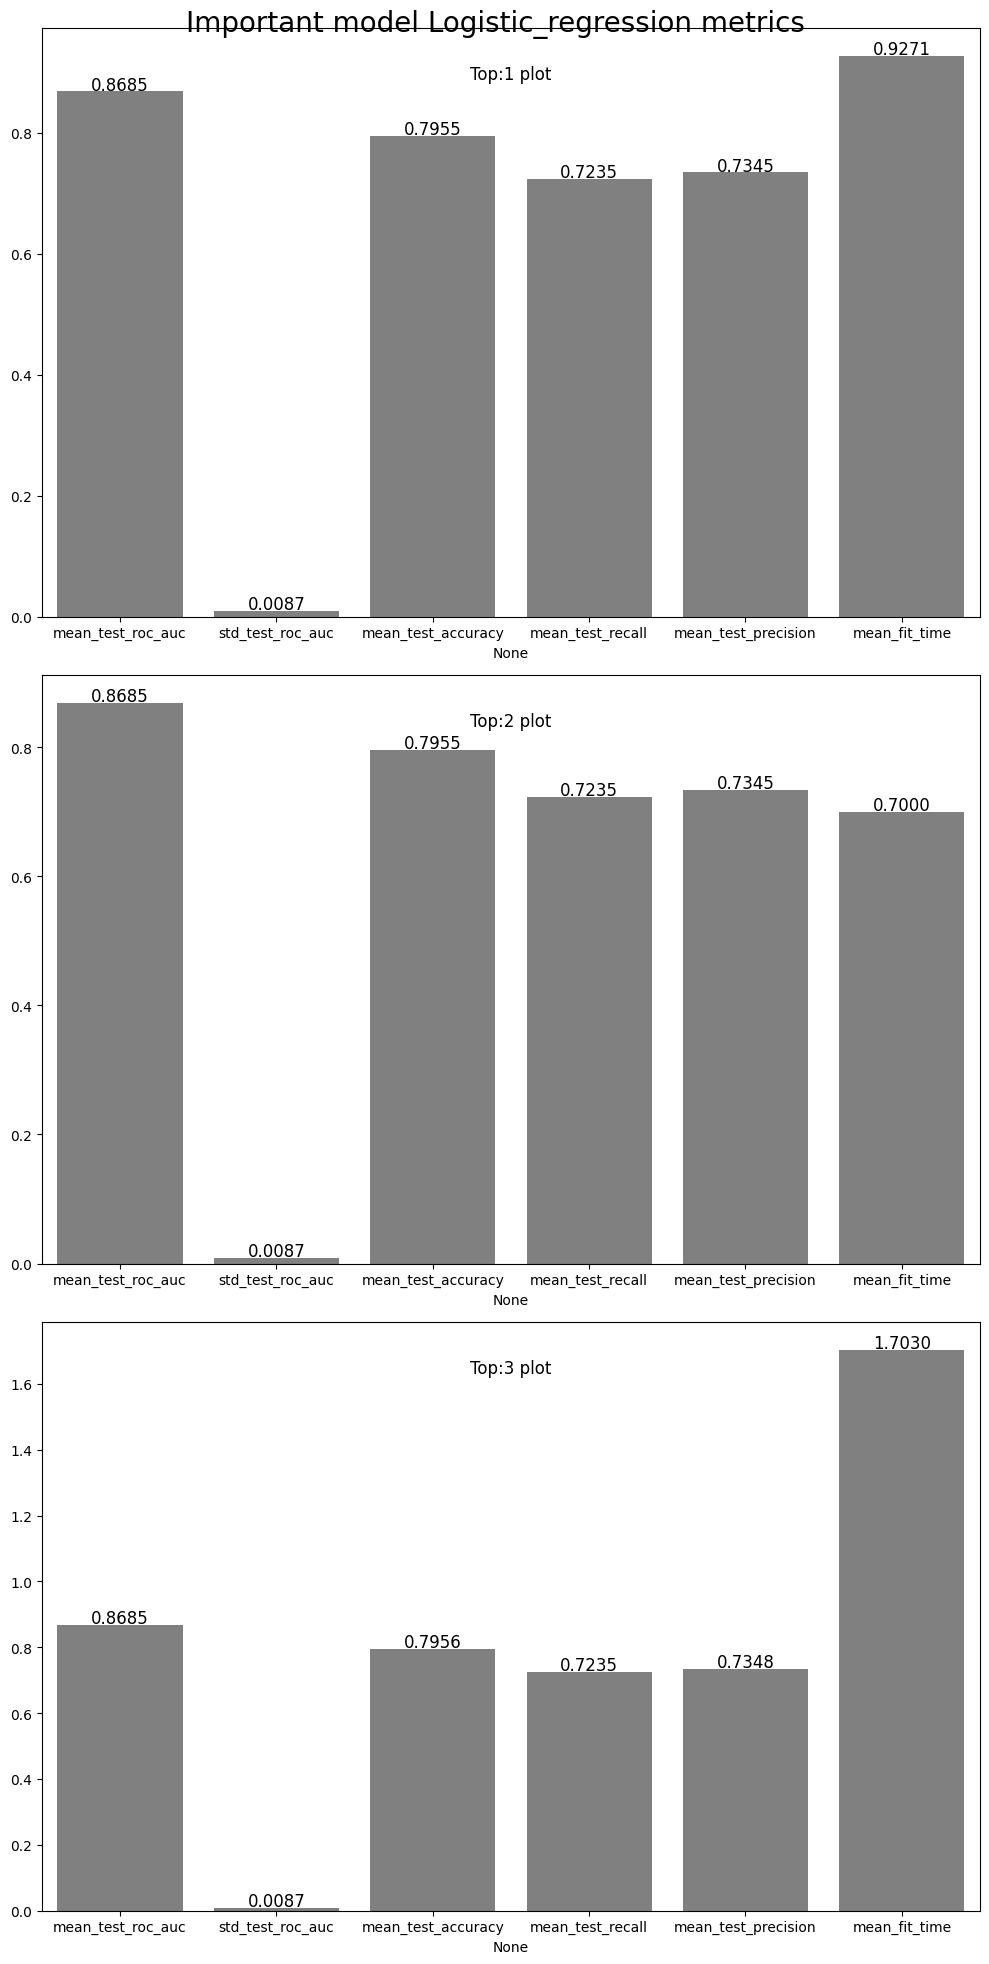

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_fit_time
33,"{'C': 100, 'max_iter': 500, 'penalty': 'l1', '...",0.868520,0.008706,0.795470,0.72355,0.734535,0.927133
37,"{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...",0.868518,0.008707,0.795470,0.72355,0.734535,0.699992
36,"{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...",0.868508,0.008694,0.795625,0.72355,0.734823,1.702959


In [ ]:
save_results(important_metrics_lr, 'lr',model_name='Logistic_regression')

In [ ]:
no1_lr = save_results(important_metrics_lr, 'lr').iloc[0]
no1_lr

Important model lr metrics


,33
params,"{'C': 100, 'max_iter': 500, 'penalty': 'l1', '..."
mean_test_roc_auc,0.86852
std_test_roc_auc,0.008706
mean_test_accuracy,0.79547
mean_test_recall,0.72355
mean_test_precision,0.734535
mean_fit_time,0.927133


In [ ]:
important_metrics_lr

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_fit_time
33,"{'C': 100, 'max_iter': 500, 'penalty': 'l1', '...",0.868520,0.008706,0.795470,0.72355,0.734535,0.927133
37,"{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...",0.868518,0.008707,0.795470,0.72355,0.734535,0.699992
36,"{'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...",0.868508,0.008694,0.795625,0.72355,0.734823,1.702959


In [ ]:
no1_lr_params = no1_lr['params']
no1_lr_params

{'C': 100, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
print(gsv_lr.best_score_)

0.8685196242100947


In [ ]:
save_results(important_metrics, gsv_best_estimator=gsv_lr.best_estimator_, gsv_res= gsv_res, model_suffix='Logisitc_regression', save=True)

Model Logisitc_regression saved


#### Loading and Testing.

In [ ]:
with open('gsv_best_estimator_Logisitc_regression.pkl', 'rb') as f:
  lr_model = pickle.load(f)

In [ ]:
y_pred_lr = lr_model.predict(X_test)

In [ ]:
print(f'''
      Accuracy: {accuracy_score(y_test, y_pred_lr)}
      Recall: {recall_score(y_test, y_pred_lr)}
      Precision: {precision_score(y_test, y_pred_lr)}
      Region_of_curve: {roc_auc_score(y_test, y_pred_lr)}
      F1 Score: {f1_score(y_test,y_pred_lr)}
''')


print(classification_report(y_test,y_pred_lr))

 
      Accuracy: 0.805316091954023
      Recall: 0.7367906066536204
      Precision: 0.7339181286549707
      Region_of_curve: 0.7909265178557545
      F1 Score: 0.7353515625

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1762
           1       0.73      0.74      0.74      1022

    accuracy                           0.81      2784
   macro avg       0.79      0.79      0.79      2784
weighted avg       0.81      0.81      0.81      2784



In [ ]:
testing_standalone_model_metrics = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr)],
    'Recall': [recall_score(y_test, y_pred_lr)],
    'Precision': [precision_score(y_test, y_pred_lr)],
    'Region_of_curve': [roc_auc_score(y_test, y_pred_lr)],
    'F1 Score': [f1_score(y_test,y_pred_lr)]
})


def add_to_testing_model_metrics(model_name, model_metrics):
  new_row_df = pd.DataFrame({
      'Model': [model_name],
      **model_metrics
  })
  testing_standalone_model_metrics_ = pd.concat([testing_standalone_model_metrics, new_row_df], ignore_index=True)
  return testing_standalone_model_metrics_

### Random forest.

In [ ]:
rfc_parameter_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt'],
    'ccp_alpha': [0.0, 0.001],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.4, 0.8],
}

gsv_rfc, gsv_res, important_metrics = build_GSV_For_models(RFC(random_state=42), parameter_grid=rfc_parameter_grid)



Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END ccp_alpha=0.0, class_weight=balanced, max_depth=15, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=2, n_estimators=200; accuracy: (train=0.867, test=0.824) precision: (train=0.845, test=0.792) recall: (train=0.796, test=0.727) roc_auc: (train=0.947, test=0.884) total time=   1.2s
[CV 2/5] END ccp_alpha=0.0, class_weight=balanced, max_depth=15, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=2, n_estimators=200; accuracy: (train=0.865, test=0.837) precision: (train=0.841, test=0.831) recall: (train=0.794, test=0.717) roc_auc: (train=0.946, test=0.889) total time=   1.1s
[CV 3/5] END ccp_alpha=0.0, class_weight=balanced, max_depth=15, max_features=sqrt, max_samples=0.4, min_samples_leaf=1, min_samples_split=2, n_estimators=200; accuracy: (train=0.857, test=0.798) precision: (train=0.788, test=0.713) recall: (train=0.851, test=0.781) roc_auc: (train=0.948, test=

Important model Random forest metrics


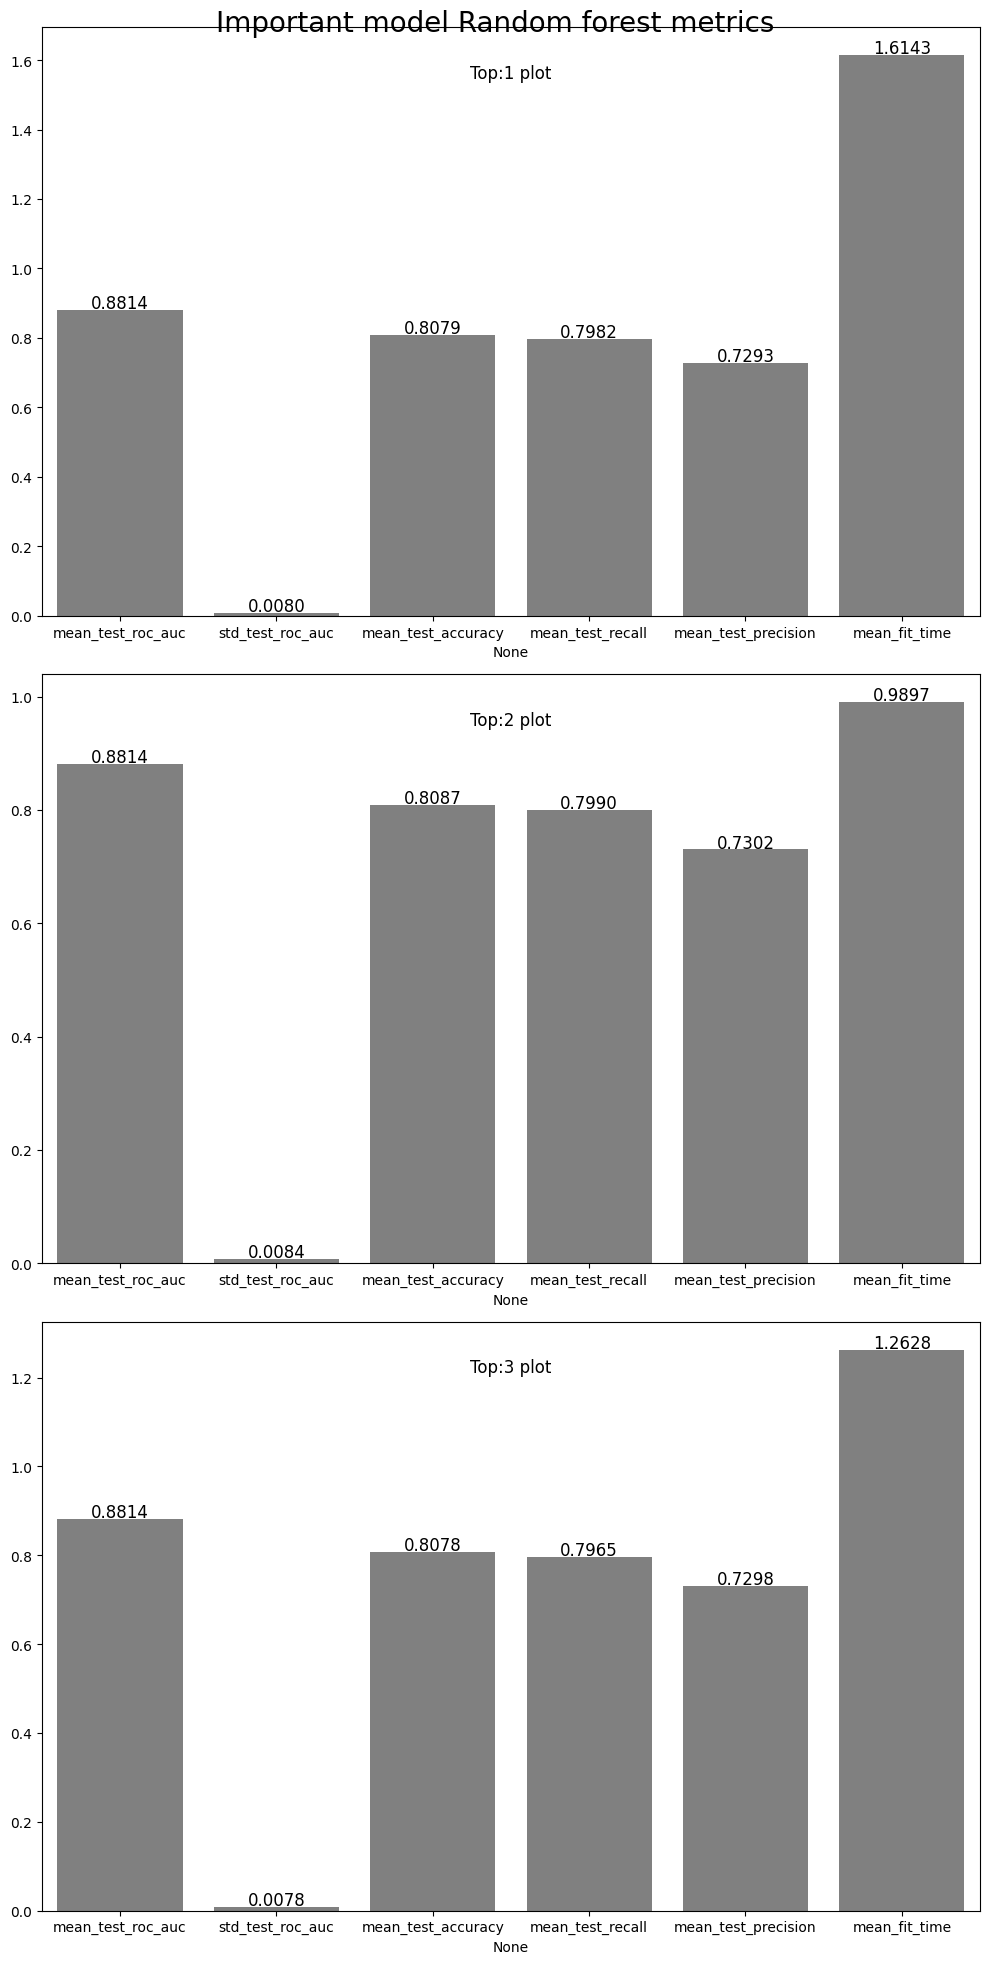

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_fit_time
61,"{'ccp_alpha': 0.0, 'class_weight': 'balanced_s...",0.881417,0.008026,0.807943,0.798167,0.729265,1.614321
62,"{'ccp_alpha': 0.0, 'class_weight': 'balanced_s...",0.881407,0.008366,0.808714,0.798980,0.730154,0.989655
13,"{'ccp_alpha': 0.0, 'class_weight': 'balanced',...",0.881406,0.007820,0.807789,0.796544,0.729835,1.262759


In [ ]:
save_results(important_metrics, model_suffix='RFC', model_name='Random forest')

In [ ]:
save_results(important_metrics, gsv_best_estimator=gsv_rfc.best_estimator_, gsv_res= gsv_res, model_suffix='Random_forest', save=True)

Model Random_forest saved


In [ ]:
def print_stats(important_metrics):
  print(f'Best Model: {important_metrics.iloc[0]}')

  print(f'Params Used: {important_metrics.iloc[0]['params']}')

print_stats(important_metrics)

Best Model: params                 {'ccp_alpha': 0.0, 'class_weight': 'balanced_s...
mean_test_roc_auc                                               0.881417
std_test_roc_auc                                                0.008026
mean_test_accuracy                                              0.807943
mean_test_recall                                                0.798167
mean_test_precision                                             0.729265
mean_fit_time                                                   1.614321
Name: 61, dtype: object
Params Used: {'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
def test_the_trained_model(model_path, model_suffix, X_test, y_test, with_proba=False,no_global=False):
  if no_global == False:
    global testing_standalone_model_metrics
  with open(model_path, 'rb') as f:
    model = pickle.load(f)

  model_name = model_path.split('.')[0]
  y_pred = model.predict(X_test)
  metrics = {
      'Accuracy': accuracy_score(y_test, y_pred),
      'Recall': recall_score(y_test, y_pred),
      'Precision': precision_score(y_test, y_pred),
      'Region_of_curve': roc_auc_score(y_test, y_pred),
      'F1 Score': f1_score(y_test,y_pred)
  }
  print(f'Model: {model_suffix}')
  for i in metrics:
    print(f'{i}: {metrics[i]}')

  if no_global == False:
    testing_standalone_model_metrics = add_to_testing_model_metrics(model_suffix, metrics)

  print(classification_report(y_test,y_pred))

  if with_proba:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return y_pred_proba


#### Loading and Testing.

In [ ]:
test_the_trained_model('gsv_best_estimator_Random_forest.pkl', 'Random_forest', X_test, y_test)

Model: Random_forest
Accuracy: 0.7977729885057471
Recall: 0.8013698630136986
Precision: 0.6946564885496184
Region_of_curve: 0.7985282913252375
F1 Score: 0.7442071785552021
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1762
           1       0.69      0.80      0.74      1022

    accuracy                           0.80      2784
   macro avg       0.78      0.80      0.79      2784
weighted avg       0.81      0.80      0.80      2784



In [ ]:
testing_standalone_model_metrics

,Model,Accuracy,Recall,Precision,Region_of_curve,F1 Score
0,Logistic Regression,0.805316,0.736791,0.733918,0.790927,0.735352
1,Random_forest,0.797773,0.801370,0.694656,0.798528,0.744207


### XGBoost

In [ ]:
parameter_grid_xg = {
    'n_estimators': [200,300],
    'max_depth': [7,9],
    'learning_rate': [0.01, 0.001],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'min_child_weight': [1, 3],
}
gsv_estimator, gsv_res, important_metrics = build_GSV_For_models(XGBClassifier(random_state=42), parameter_grid=parameter_grid_xg, cv=3)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.839, test=0.830) precision: (train=0.817, test=0.824) recall: (train=0.741, test=0.704) roc_auc: (train=0.903, test=0.895) total time=   1.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.836, test=0.818) precision: (train=0.822, test=0.795) recall: (train=0.727, test=0.703) roc_auc: (train=0.909, test=0.878) total time=   0.7s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.848, test=0.802) precision: (train=0.839, test=0.765) recall: (train=0.740, test=0.691) roc_auc: (train=0.910, test=0.872) total time=   0.5s
[CV 1/3] END colsample_b

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.895) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.876) total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.895) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.705) precision: (train=0.945, test=0.955) recall: (train=0.252, test=0.235) roc_auc: (train=0.893, test=0.895) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.710) precision: (train=0.958, test=0.930) recall: (train=0.249, test=0.257) roc_auc: (train=0.900, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.889, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.889, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.704) precision: (train=0.945, test=0.955) recall: (train=0.249, test=0.232) roc_auc: (train=0.889, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.709) precision: (train=0.957, test=0.929) recall: (train=0.245, test=0.254) roc_auc: (train=0.896, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=7, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.878) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.878) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.910, test=0.869) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.878) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.869) total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.705) precision: (train=0.945, test=0.955) recall: (train=0.252, test=0.235) roc_auc: (train=0.901, test=0.895) total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.710) precision: (train=0.958, test=0.929) recall: (train=0.250, test=0.255) roc_auc: (train=0.909, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.893) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.904, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.704) precision: (train=0.945, test=0.955) recall: (train=0.249, test=0.232) roc_auc: (train=0.894, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.709) precision: (train=0.957, test=0.929) recall: (train=0.246, test=0.254) roc_auc: (train=0.902, test=0.879) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_depth=9, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.895) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.705) precision: (train=0.945, test=0.955) recall: (train=0.252, test=0.235) roc_auc: (train=0.893, test=0.895) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.249, test=0.258) roc_auc: (train=0.900, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.889, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.704) precision: (train=0.945, test=0.955) recall: (train=0.249, test=0.232) roc_auc: (train=0.889, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.709) precision: (train=0.957, test=0.929) recall: (train=0.245, test=0.254) roc_auc: (train=0.896, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.878) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.869) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.869) total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.705) precision: (train=0.945, test=0.955) recall: (train=0.252, test=0.235) roc_auc: (train=0.901, test=0.895) total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.710) precision: (train=0.958, test=0.930) recall: (train=0.250, test=0.257) roc_auc: (train=0.908, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.879) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.704) precision: (train=0.945, test=0.955) recall: (train=0.249, test=0.232) roc_auc: (train=0.894, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.709) precision: (train=0.957, test=0.929) recall: (train=0.246, test=0.254) roc_auc: (train=0.902, test=0.878) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.705) precision: (train=0.945, test=0.955) recall: (train=0.252, test=0.235) roc_auc: (train=0.892, test=0.895) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.249, test=0.258) roc_auc: (train=0.900, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.889, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.868) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.704) precision: (train=0.945, test=0.955) recall: (train=0.249, test=0.232) roc_auc: (train=0.889, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.709) precision: (train=0.957, test=0.929) recall: (train=0.245, test=0.254) roc_auc: (train=0.896, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.869) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.870) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.877) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.869) total time=   0.8s
[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.705) precision: (train=0.945, test=0.955) recall: (train=0.252, test=0.235) roc_auc: (train=0.901, test=0.895) total time=   1.0s
[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.710) precision: (train=0.958, test=0.930) recall: (train=0.250, test=0.257) roc_auc: (train=0.908, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.893) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.704) precision: (train=0.945, test=0.955) recall: (train=0.249, test=0.232) roc_auc: (train=0.894, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.709, test=0.709) precision: (train=0.957, test=0.929) recall: (train=0.246, test=0.254) roc_auc: (train=0.901, test=0.878) total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.706) precision: (train=0.945, test=0.956) recall: (train=0.251, test=0.237) roc_auc: (train=0.892, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.712, test=0.713) precision: (train=0.958, test=0.931) recall: (train=0.252, test=0.264) roc_auc: (train=0.899, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.887, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.876) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.706) precision: (train=0.945, test=0.956) recall: (train=0.250, test=0.238) roc_auc: (train=0.888, test=0.893) total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.248, test=0.259) roc_auc: (train=0.895, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=7, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.869) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.870) total time=   1.9s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.869) total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.716, test=0.710) precision: (train=0.948, test=0.958) recall: (train=0.266, test=0.248) roc_auc: (train=0.901, test=0.894) total time=   1.8s
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.713, test=0.713) precision: (train=0.959, test=0.931) recall: (train=0.255, test=0.264) roc_auc: (train=0.908, test=0.878) total time=   1.9s
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.892) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.903, test=0.868) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.892) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.707) precision: (train=0.945, test=0.956) recall: (train=0.251, test=0.239) roc_auc: (train=0.894, test=0.893) total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.711, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.249, test=0.259) roc_auc: (train=0.901, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=9, min_c

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.706) precision: (train=0.945, test=0.956) recall: (train=0.251, test=0.237) roc_auc: (train=0.892, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.712, test=0.713) precision: (train=0.958, test=0.931) recall: (train=0.252, test=0.264) roc_auc: (train=0.899, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.867) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.887, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.706) precision: (train=0.945, test=0.956) recall: (train=0.250, test=0.238) roc_auc: (train=0.888, test=0.893) total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.248, test=0.259) roc_auc: (train=0.895, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.909, test=0.869) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.870) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.877) total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.869) total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.716, test=0.710) precision: (train=0.948, test=0.958) recall: (train=0.266, test=0.248) roc_auc: (train=0.901, test=0.894) total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.713, test=0.713) precision: (train=0.959, test=0.931) recall: (train=0.255, test=0.263) roc_auc: (train=0.908, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   3.1s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   1.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.892) total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.878) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.6s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   1.0s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.8s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.7s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   0.8s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.9s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   2.8s
[CV 1/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.707) precision: (train=0.945, test=0.956) recall: (train=0.251, test=0.239) roc_auc: (train=0.894, test=0.892) total time=   1.0s
[CV 2/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.249, test=0.259) roc_auc: (train=0.901, test=0.878) total time=   1.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.5s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.869) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.891, test=0.894) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.898, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.869) total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.706) precision: (train=0.945, test=0.956) recall: (train=0.250, test=0.237) roc_auc: (train=0.892, test=0.894) total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.712, test=0.713) precision: (train=0.958, test=0.931) recall: (train=0.252, test=0.263) roc_auc: (train=0.899, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.895, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.887, test=0.893) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.888, test=0.893) total time=   0.4s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.876) total time=   1.1s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.897, test=0.867) total time=   0.4s
[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.706) precision: (train=0.945, test=0.956) recall: (train=0.250, test=0.238) roc_auc: (train=0.888, test=0.893) total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=7, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.248, test=0.259) roc_auc: (train=0.895, test=0.877) total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.908, test=0.869) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.905, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.870) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.894) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.906, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.907, test=0.869) total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.716, test=0.710) precision: (train=0.948, test=0.958) recall: (train=0.266, test=0.248) roc_auc: (train=0.900, test=0.894) total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=1, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.713, test=0.713) precision: (train=0.959, test=0.931) recall: (train=0.255, test=0.263) roc_auc: (train=0.908, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.878) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.894, test=0.892) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.877) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.892, test=0.892) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.899, test=0.878) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.8; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.901, test=0.868) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.893, test=0.892) total time=   0.2s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.900, test=0.877) total time=   0.3s


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=200, reg_alpha=0.1, subsample=0.9; accuracy: (train=0.620, test=0.620) precision: (train=0.000, test=0.000) recall: (train=0.000, test=0.000) roc_auc: (train=0.902, test=0.868) total time=   0.3s
[CV 1/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.707) precision: (train=0.945, test=0.956) recall: (train=0.251, test=0.239) roc_auc: (train=0.893, test=0.893) total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=9, min_child_weight=3, n_estimators=300, reg_alpha=0, subsample=0.8; accuracy: (train=0.710, test=0.711) precision: (train=0.958, test=0.930) recall: (train=0.249, test=0.259) roc_auc: (train=0.901, test=0.878) total time=   0.4s
[CV 3/3] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=

Important model XGBoost metrics


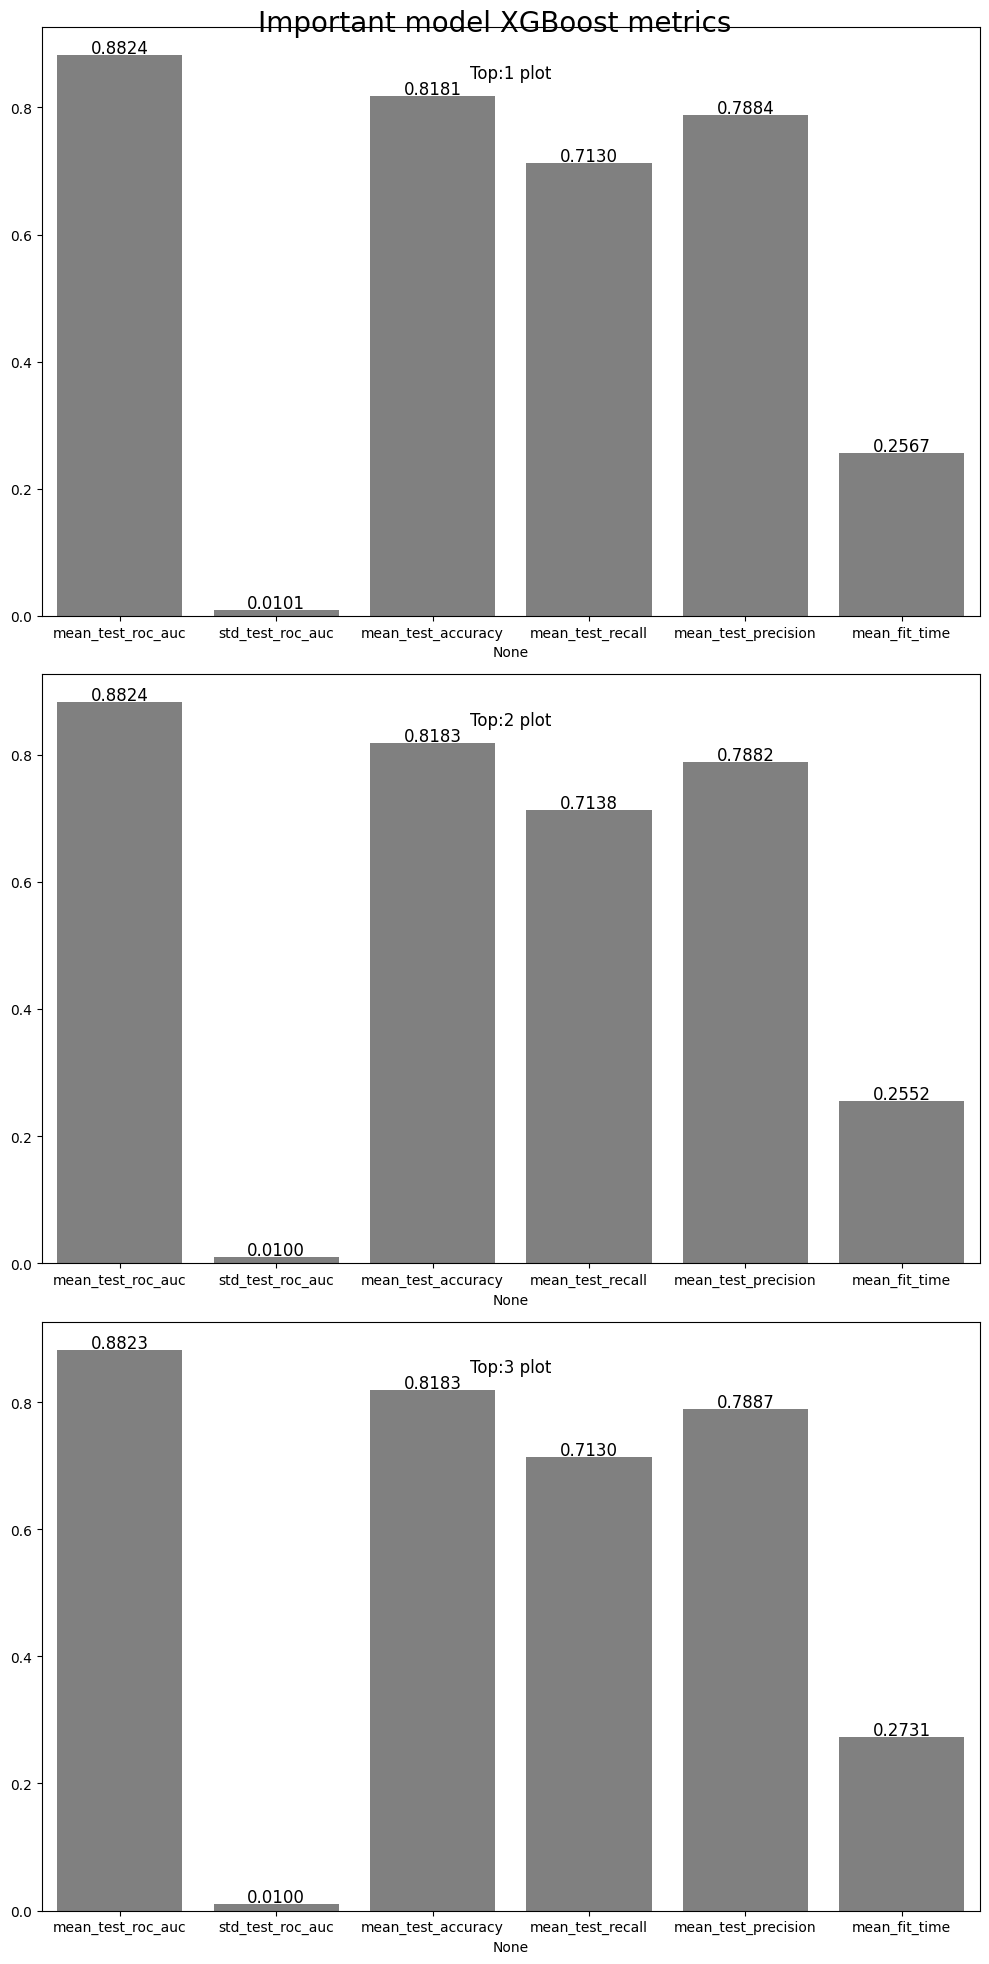

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_fit_time
134,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learn...",0.882401,0.010083,0.818110,0.713010,0.788390,0.256721
132,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learn...",0.882368,0.010041,0.818264,0.713821,0.788236,0.255215
70,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",0.882346,0.010023,0.818264,0.713010,0.788742,0.273065


In [ ]:
save_results(important_metrics, model_suffix='XGB', model_name='XGBoost')

In [ ]:
save_results(important_metrics, gsv_best_estimator=gsv_estimator.best_estimator_, gsv_res= gsv_res, model_suffix='XGBoost', save=True)

Model XGBoost saved


#### Loading and Testing

In [ ]:
test_the_trained_model('gsv_best_estimator_XGBoost.pkl', 'XGBoost', X_test, y_test)

Model: XGBoost
Accuracy: 0.8099856321839081
Recall: 0.7045009784735812
Precision: 0.7602956705385427
Region_of_curve: 0.7878350522333853
F1 Score: 0.7313357034027425
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1762
           1       0.76      0.70      0.73      1022

    accuracy                           0.81      2784
   macro avg       0.80      0.79      0.79      2784
weighted avg       0.81      0.81      0.81      2784



### Support Vector Classifier

In [ ]:
parameter_grid_svc = {
    "C": [0.5, 0.8, 0.1],
    "kernel": ['poly', 'rbf', 'linear'],
    "degree": [3, 5, 7],
    "gamma": ["scale", "auto"],
    "shrinking": [False, True],
}

gsv_estimator, gsv_res, important_metrics = build_GSV_For_models(
    SVC(random_state=42, class_weight='balanced',probability=True),
    parameter_grid=parameter_grid_svc,
    cv=3
)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END C=0.5, degree=3, gamma=scale, kernel=poly, shrinking=False; accuracy: (train=0.804, test=0.820) precision: (train=0.747, test=0.777) recall: (train=0.733, test=0.740) roc_auc: (train=0.861, test=0.873) total time=   1.1s
[CV 2/3] END C=0.5, degree=3, gamma=scale, kernel=poly, shrinking=False; accuracy: (train=0.810, test=0.810) precision: (train=0.760, test=0.761) recall: (train=0.732, test=0.729) roc_auc: (train=0.873, test=0.865) total time=   1.4s
[CV 3/3] END C=0.5, degree=3, gamma=scale, kernel=poly, shrinking=False; accuracy: (train=0.819, test=0.801) precision: (train=0.764, test=0.735) recall: (train=0.757, test=0.743) roc_auc: (train=0.875, test=0.858) total time=   0.8s
[CV 1/3] END C=0.5, degree=3, gamma=scale, kernel=poly, shrinking=True; accuracy: (train=0.804, test=0.820) precision: (train=0.747, test=0.777) recall: (train=0.733, test=0.740) roc_auc: (train=0.861, test=0.873) total time=   0.8s
[C

Important model Support Vector Classifier metrics


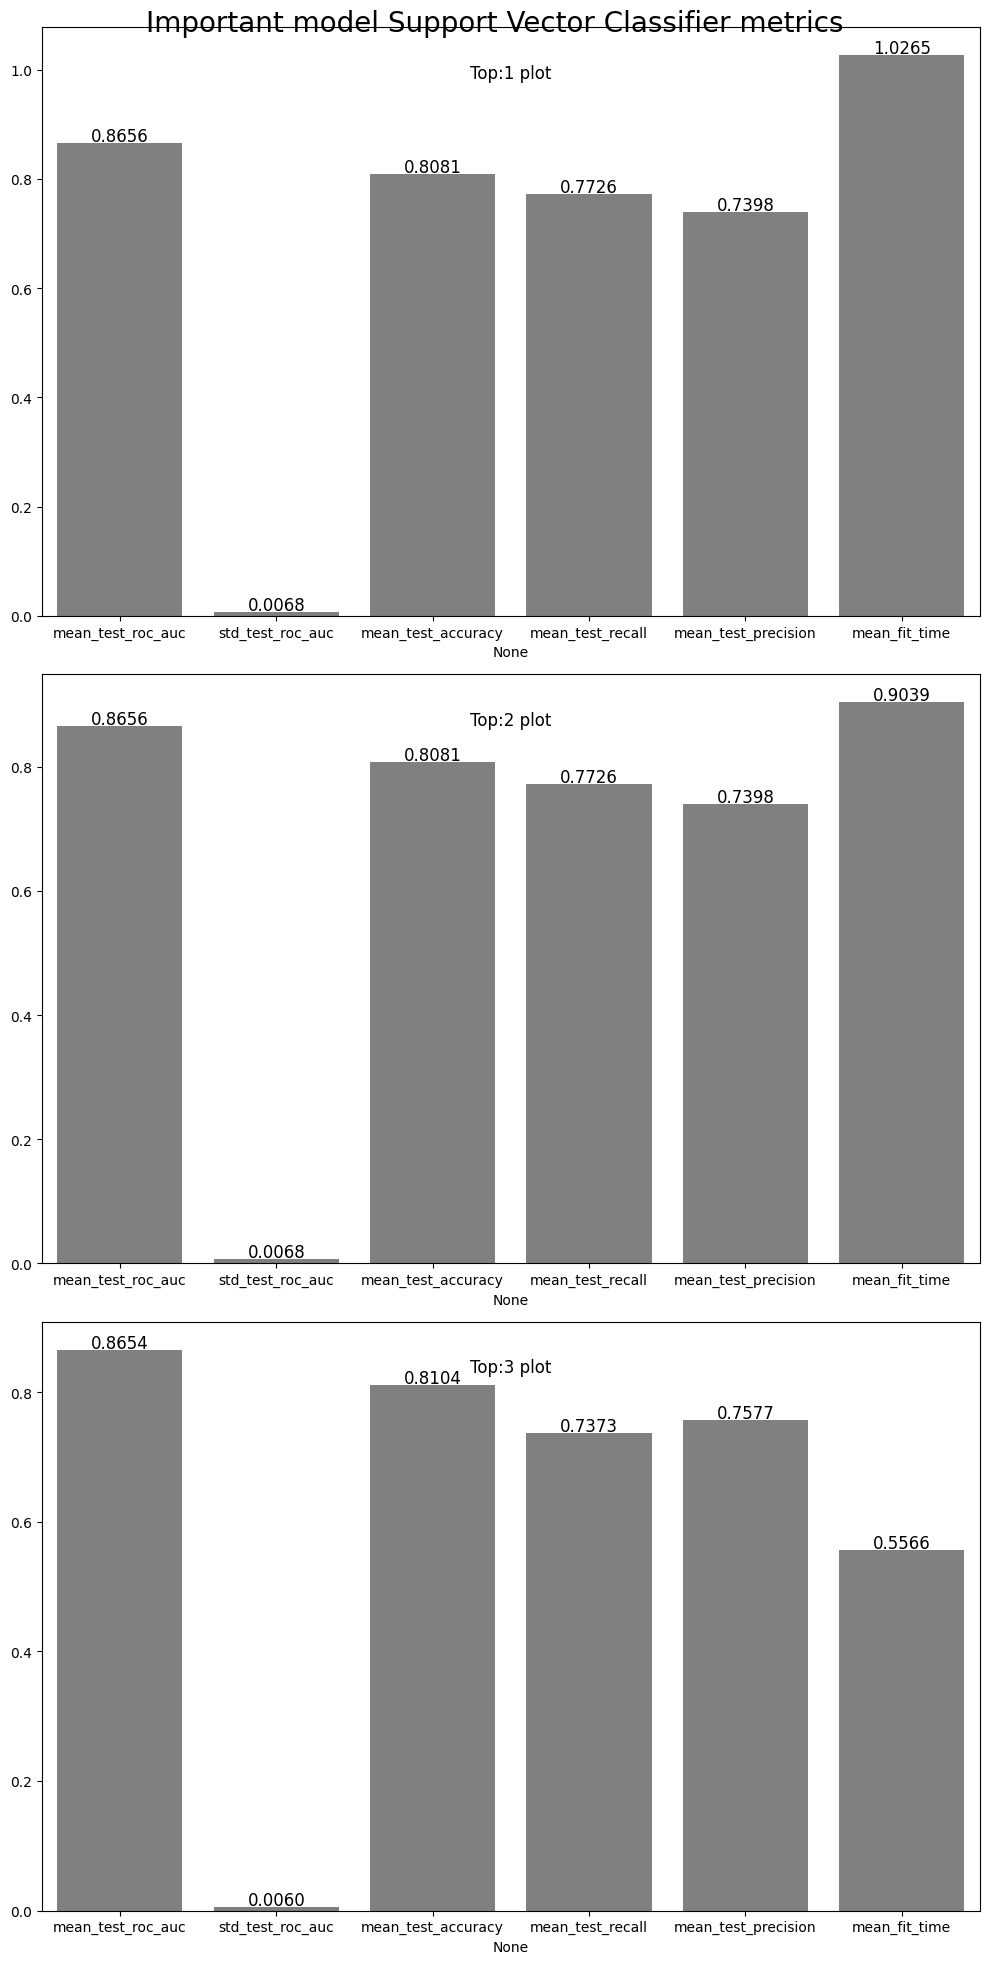

,params,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_fit_time
37,"{'C': 0.8, 'degree': 3, 'gamma': 'scale', 'ker...",0.865632,0.006800,0.808099,0.772611,0.739753,1.026520
36,"{'C': 0.8, 'degree': 3, 'gamma': 'scale', 'ker...",0.865615,0.006793,0.808099,0.772611,0.739753,0.903948
1,"{'C': 0.5, 'degree': 3, 'gamma': 'scale', 'ker...",0.865418,0.005966,0.810410,0.737332,0.757721,0.556621


In [ ]:
save_results(important_metrics, model_suffix='SVC', model_name='Support Vector Classifier')

In [ ]:
save_results(important_metrics, gsv_best_estimator=gsv_estimator.best_estimator_, gsv_res= gsv_res, model_suffix='SVC', save=True)

Model SVC saved


#### Loading and Testing

In [ ]:
test_the_trained_model('gsv_best_estimator_SVC.pkl', 'SVC', X_test, y_test)

Model: SVC
Accuracy: 0.8035201149425287
Recall: 0.7436399217221135
Precision: 0.7272727272727273
Region_of_curve: 0.7909459540506141
F1 Score: 0.7353652636671505
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1762
           1       0.73      0.74      0.74      1022

    accuracy                           0.80      2784
   macro avg       0.79      0.79      0.79      2784
weighted avg       0.80      0.80      0.80      2784



## Standalone Model Results Exploration

### Saving essential results.


In [ ]:
testing_standalone_model_metrics.to_csv('testing_standalone_model_metrics.csv', index=False)

deleting global variables cause i dont want to hav problems with the collab.

In [ ]:
del testing_standalone_model_metrics
globals().get('testing_standalone_model_metrics')

In [ ]:
def top_10_best_estimators_workbook_creator(top=10):
  book = Workbook()
  suffix = ['XGBoost', 'SVC', 'Random_forest', 'Logisitc_regression']
  for i in suffix:
    df = pd.read_csv(f'gsv_res_{i}.csv')
    df = df.sort_values(by='mean_test_roc_auc', ascending=False).head(top)
    sheet = book.create_sheet(i)
    sheet.append(df.columns.tolist())
    for row in df.values.tolist():
      sheet.append(row)

  if 'Sheet' in book.sheetnames:
      del book['Sheet']
  if 'Sheet1' in book.sheetnames:
      del book['Sheet1']

  book.save('best_estimators.xlsx')

In [ ]:
top_10_best_estimators_workbook_creator()

### Loading Expolaration details.

In [ ]:
def extract_imp_metrics_from_best_estimators():
    relevent_info = {}
    suffix = ['XGBoost', 'SVC', 'Random_forest', 'Logisitc_regression']

    all_sheets = pd.read_excel('best_estimators.xlsx', sheet_name=suffix)
    imp_cols = [
            'params',
            'mean_test_roc_auc',
            'std_test_roc_auc',
            'mean_test_accuracy',
            'mean_test_recall',
            'mean_test_precision',
            'mean_fit_time',
        ]
    estimators_imp_metrics_df = pd.DataFrame({
        'name': [],
        **{col: [] for col in imp_cols}
    })


    for i in suffix:
        best_estimators = all_sheets[i].head(1)

        imp_metrics_best_estimators_df = best_estimators[imp_cols].copy()

        imp_metrics_best_estimators_df['name'] = i

        estimators_imp_metrics_df = pd.concat([estimators_imp_metrics_df, imp_metrics_best_estimators_df], ignore_index=True)



    return estimators_imp_metrics_df

In [ ]:
standlone_train_set_metrics = extract_imp_metrics_from_best_estimators()

In [ ]:
standalone_test_set_metrics = pd.read_csv('standalone_model_test_metrics_consolidated.csv')


In [ ]:
standlone_train_set_metrics

,name,params,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_fit_time
0,XGBoost,"{'colsample_bytree': 0.8, 'gamma': 0.2, 'learn...",0.882401,0.010083,0.818110,0.713010,0.788390,0.256721
1,SVC,"{'C': 0.8, 'degree': 3, 'gamma': 'scale', 'ker...",0.865632,0.006800,0.808099,0.772611,0.739753,1.026520
2,Random_forest,"{'ccp_alpha': 0.0, 'class_weight': 'balanced_s...",0.881417,0.008026,0.807943,0.798167,0.729265,1.614321
3,Logisitc_regression,"{'C': 100, 'max_iter': 500, 'penalty': 'l1', '...",0.868520,0.008706,0.795470,0.723550,0.734535,0.927133


In [ ]:
standalone_test_set_metrics

,Model,Accuracy,Recall,Precision,Region_of_curve,F1 Score
0,Logistic Regression,0.805316,0.736791,0.733918,0.790927,0.735352
1,Random_forest,0.797773,0.801370,0.694656,0.798528,0.744207
2,XGBoost,0.809986,0.704501,0.760296,0.787835,0.731336
3,SVC,0.803520,0.743640,0.727273,0.790946,0.735365


### Visualizaiton of the standalone results.

#### Train results.

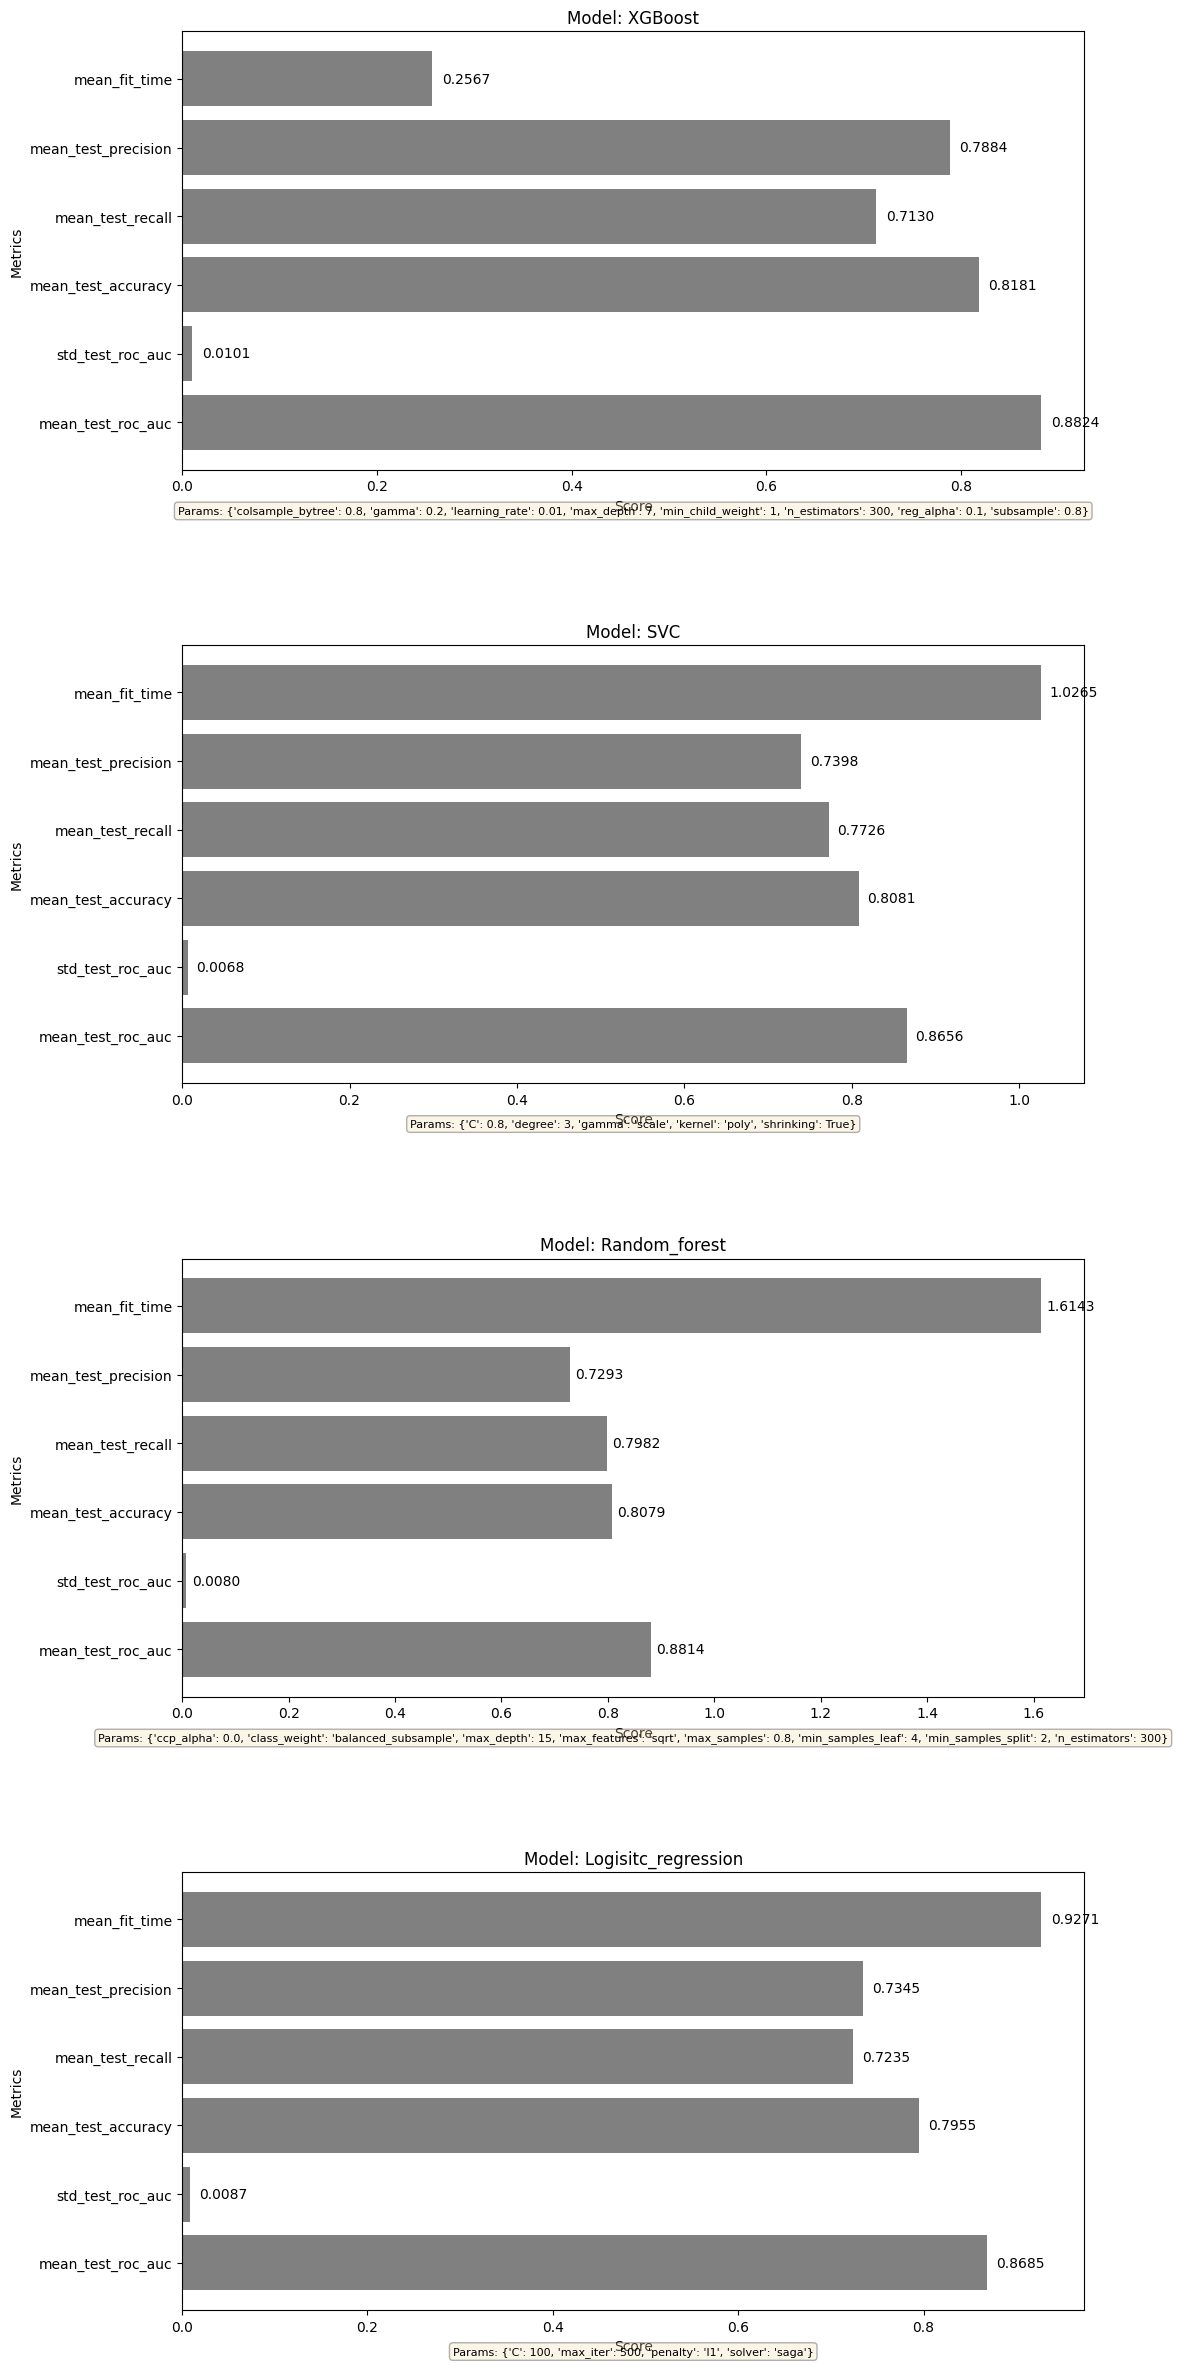

In [ ]:
def visualize_best_estimators_metrics():
    models = standlone_train_set_metrics['name'].unique()

    fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(12, 6*len(models)))

    if len(models) == 1:
        axes = [axes]

    metric_cols = ['mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy',
                   'mean_test_recall', 'mean_test_precision', 'mean_fit_time']

    for idx, model in enumerate(models):
        ax = axes[idx]

        model_data = standlone_train_set_metrics[standlone_train_set_metrics['name'] == model]
        metrics = model_data[metric_cols].iloc[0]
        params = model_data['params'].iloc[0]

        ax.barh(metrics.index, metrics.values, color='grey')

        for i, (metric, value) in enumerate(metrics.items()):
            ax.text(value + 0.01, i, f'{value:.4f}',
                   ha='left', va='center', fontsize=10, color='black')

        ax.set_xlabel('Score')
        ax.set_ylabel('Metrics')
        ax.set_title(f'Model: {model}')

        ax.text(0.5, -0.1, f'Params: {params}', transform=ax.transAxes,
               fontsize=8, ha='center', wrap=True,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))


    fig.tight_layout(pad=2.0)
    plt.subplots_adjust(hspace=0.4)

    plt.dpi = 300
    plt.show()

visualize_best_estimators_metrics()

##### Insights



TRAINING SET ANALYSIS - Hyperparameter Optimization Results

CROSS-VALIDATION PERFORMANCE (5-Fold):

1. TRAINING CONSISTENCY:
   - All models show mean_train metrics with low standard deviations (std < 0.011)
   - Indicates stable training across different data splits
   - Low variance = reliable hyperparameter selection via GridSearchCV

2. OVERFITTING CHECK:
   - Compare mean_train vs mean_test metrics for each model
   - Train-test gap indicates generalization capacity
   - Models with smaller gaps generalize better to unseen data

3. HYPERPARAMETER IMPACT:
   - XGBoost: Learning rate 0.01 with regularization (gamma=0.2, reg_alpha=0.1)
     → Controls overfitting while maintaining performance
   - Random Forest: Balanced sampling (max_samples=0.8, class_weight='balanced_subsample')
     → Handles class imbalance effectively
   - SVC: Polynomial kernel (degree=3, C=0.8) → Moderate complexity, prevents overfitting
   - Logistic Regression: L1 penalty (C=100) → Feature selection with flexibility

4. TRAINING EFFICIENCY:
   - XGBoost trains fastest (0.26s) despite complex boosting
   - Random Forest slowest (1.61s) due to 300 independent trees
   - Acceptable training times for all models (<2s per fold)

5. SELECTED CONFIGURATIONS:
   Each model's hyperparameters were chosen based on best mean_test_roc_auc,
   ensuring the selected configuration generalizes well rather than just
   fitting the training data perfectly.

KEY TAKEAWAY:
Low standard deviations and consistent mean_fit_times confirm that GridSearchCV
successfully identified robust hyperparameter configurations. These optimized
models are ready for stacking without overfitting concerns.


#### Test results

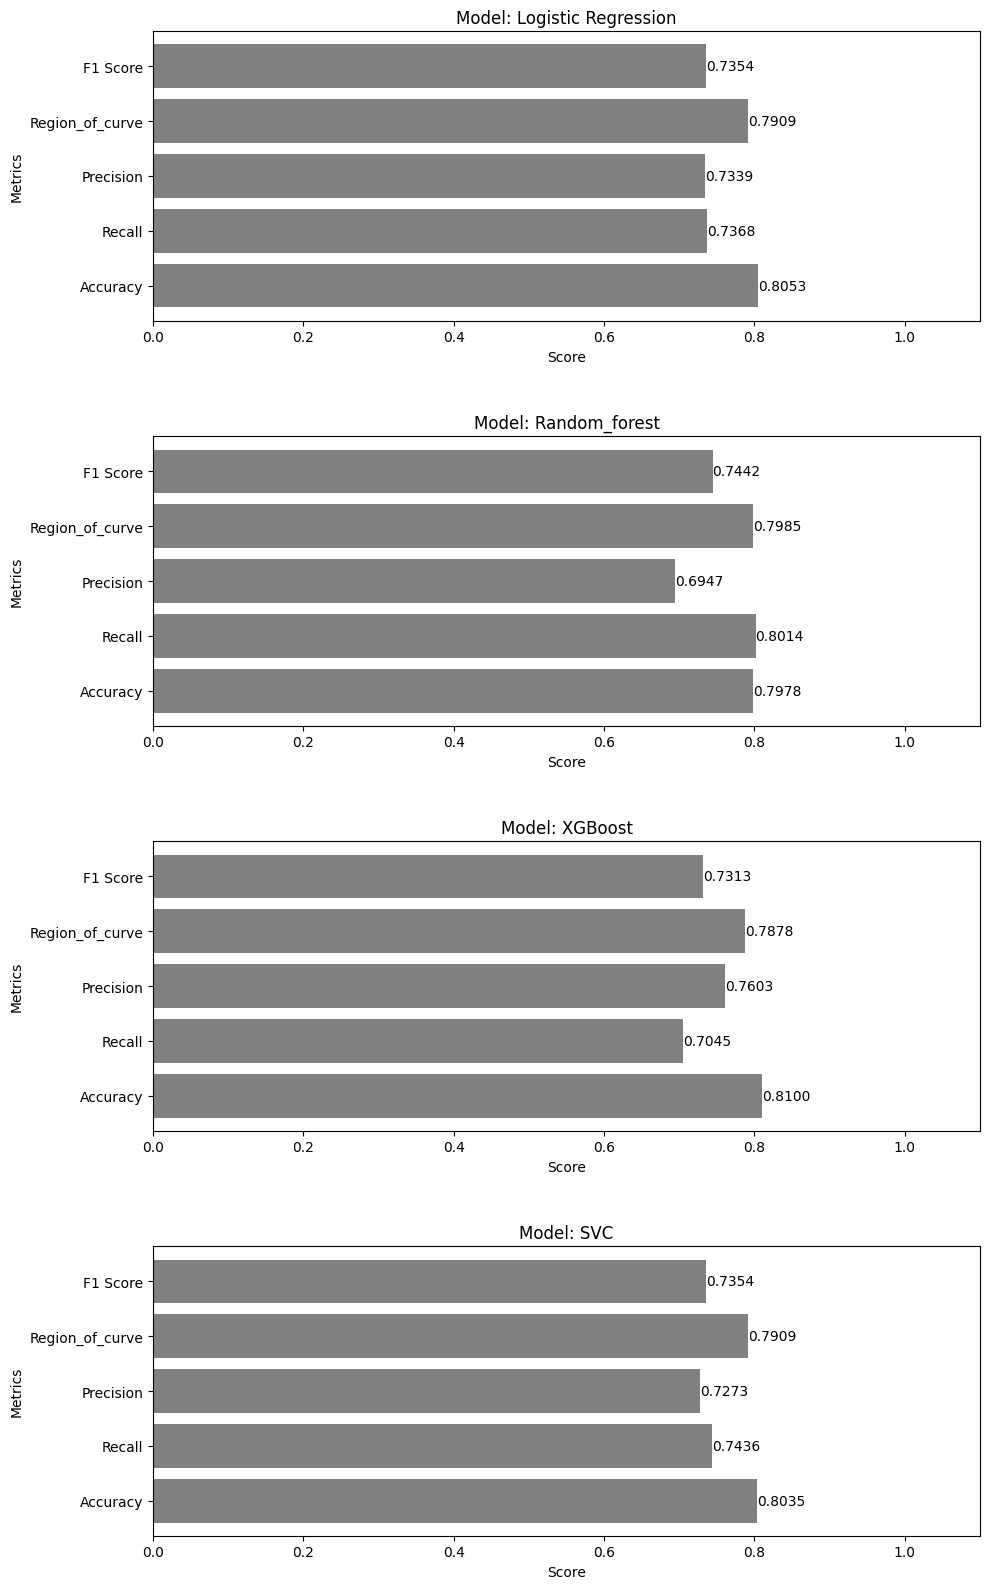

In [ ]:
def visualize_standalone_model_test_metrics():
    standalone_test_set_metrics = pd.read_csv('standalone_model_test_metrics_consolidated.csv')
    models = standalone_test_set_metrics['Model'].unique()

    fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(10, 4*len(models)))

    if len(models) == 1:
        axes = [axes]

    for idx, model in enumerate(models):
        ax = axes[idx]

        data = standalone_test_set_metrics[standalone_test_set_metrics['Model'] == model].drop('Model', axis=1)

        metrics = data.iloc[0]
        ax.barh(metrics.index, metrics.values, color='grey')

        for i, (metric, value) in enumerate(metrics.items()):
            ax.text(value, i, f'{value:.4f}',
                   ha='left', va='center', fontsize=10, color='black')

        ax.set_xlabel('Score')
        ax.set_ylabel('Metrics')
        ax.set_title(f'Model: {model}')
        ax.set_xlim(0, 1.1)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.dpi = 300
    plt.show()

visualize_standalone_model_test_metrics()

##### Insights


STACKING RATIONALE:

These 4 models demonstrate complementary strengths ideal for stacking:

- Random Forest: Best recall (0.80) - catches most conversions
- XGBoost: Best precision (0.76) & accuracy (0.81) - reliable predictions  
- Logistic Regression & SVC: Balanced performers with similar ROC-AUC

KEY ADVANTAGES FOR STACKING:
1. Diversity: Each model uses different learning algorithms (trees, boosting,
   linear, kernel) → captures different patterns
2. Similar ROC-AUC (0.79-0.80): All models are competent but likely excel in
   different scenarios
3. Precision-Recall Trade-off: RF prioritizes recall, XGB prioritizes precision
   → Meta-learner can optimize this balance

EXPECTED OUTCOME:
The meta-learner will learn when to trust each model's predictions, combining
their strengths to achieve:
- ROC-AUC > 0.82 (current best: 0.80)
- Better precision-recall balance
- More robust predictions across different data scenarios

This is the core principle of stacking: "the whole is greater than the sum of parts"

## Model Building Stacked generalization

### Generating off-fold predictions.



So, the process goes like this,
- We need X_meta_test, y_test to get the predictions of stacked generalization model

- We need X_meta_train, y_train for training.


How to generate X_meta_train.
- We know the x_meta_train is the stacked predicitons of meta_Model: Neural network (for our case).

- We cannot use X_test for getting X_meta_train from the predictions of standalone model cause the pred form meta model from will be minimum, training data cannot be more than testing data if we going to use train_data for testing the meta_model.

So We need to come with the way to create X_meta_train, thats crossfold comes.

Say you have 100 samples for training with cross-validation of 5 - meaning the data set will divided into 5, and model is built 5 times.

1 2 3 4 5 (each set with 20 rows).

so I will use 1st set as test set and 2,3,4,5 combined as train set.
Predictions are made.

2 -> Test set
1,3,4,5 - Train Set
Predictions are made.


3 -> Test Set
1,2,4,5 -> Train Set.
Predictions are made.

4 -> Test
Remaining train
Predictions are made.

5 -> Test
Reamining Train.
Predictions are made.


So, If one understood the pattern -  each time when model is built it never seen the test split meaning, the predictions on the Test split is predicitions of unseen data.

Each iteration the test split is different, So, obtaining the prediction (which we also call as OFF_Predication) and stacking them gives us y_pred for entrire training_set.


The above process is continued all the models and stacked to give X_meta_train in which NN is trained.

Metrics for training is calculated by y_pred_meta_train and true labels.

Now, X_meta_test must be similar to X_meta_train,

We use standalone models to predict on x_test to give X_meta_test.

Metrics for testing x_meta_test is calculated by y_test, y_pred_meta_test.






#### Load sets.

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

#### Logisitic Regression

In [ ]:
def exrtract_params_from_best_estimators(model_name):
  params_string = standlone_train_set_metrics[standlone_train_set_metrics['name'] == model_name]['params'].iloc[0]
  params = ast.literal_eval(params_string)
  return params



In [ ]:
lr_model_for_off = LR(random_state=42,**exrtract_params_from_best_estimators('Logisitc_regression'),class_weight='balanced')


In [ ]:
lr_model_off = CVP(lr_model_for_off, X_train, y_train, cv=5,method='predict_proba')

In [ ]:
lr_model_off

array([[0.14223447, 0.85776553],
       [0.12493546, 0.87506454],
       [0.58496864, 0.41503136],
       ...,
       [0.05199648, 0.94800352],
       [0.64338568, 0.35661432],
       [0.46903254, 0.53096746]])

The structure above is a probability of thr sample to be postive and negative[negative class (0), Positive class (1)]

We only need Postive class cause this is standard pratice, either can be use.

In [ ]:
lr_model_off = lr_model_off[:, 1]

#### Random forest

In [ ]:
rf_best_parms = exrtract_params_from_best_estimators('Random_forest')
RF_model_for_off = RFC(random_state=42,**rf_best_parms)

rf_off = CVP(estimator=RF_model_for_off, X=X_train, y=y_train, cv=5, method='predict_proba')[:, 1]

#### XGBoost

In [ ]:
xgb_best_parms = exrtract_params_from_best_estimators('XGBoost')
xgb_model_for_off = XGBClassifier(random_state=42,**xgb_best_parms)
xgb_off = CVP(estimator=xgb_model_for_off, X=X_train, y=y_train, cv=5, method='predict_proba')[:, 1]

#### SVC

In [ ]:
svc_best_parms = exrtract_params_from_best_estimators('SVC')
svc_model_for_off = SVC(random_state=42, probability=True, **svc_best_parms, class_weight='balanced')
svc_off = CVP(estimator=svc_model_for_off, X=X_train, y=y_train, cv=5, method='predict_proba')


array([[0.20474696, 0.79525304],
       [0.26926535, 0.73073465],
       [0.77732356, 0.22267644],
       ...,
       [0.11070865, 0.88929135],
       [0.83371685, 0.16628315],
       [0.5       , 0.5       ]])

In [ ]:
svc_off = svc_off[:, 1]

### Stacking off_pred X_meta_train

In [ ]:
X_meta_train = np.column_stack([lr_model_off, rf_off, xgb_off, svc_off])x

In [ ]:
X_meta_train

array([[0.85776553, 0.77800208, 0.73044115, 0.79525304],
       [0.87506454, 0.9029788 , 0.81137323, 0.73073465],
       [0.41503136, 0.48623824, 0.37210208, 0.22267644],
       ...,
       [0.94800352, 0.96053868, 0.91773528, 0.88929135],
       [0.35661432, 0.18131649, 0.14045379, 0.16628315],
       [0.53096746, 0.68623358, 0.5761025 , 0.5       ]])

In [ ]:
pd.DataFrame(X_meta_train,columns=['lr_model_off', 'rf_off', 'xgb_off', 'svc_off']).to_csv('X_meta_train.csv', index=False)

In [ ]:
X_meta_train = pd.read_csv('X_meta_train.csv')

In [ ]:
X_meta_train

,lr_model_off,rf_off,xgb_off,svc_off
0,0.857766,0.778002,0.730441,0.795253
1,0.875065,0.902979,0.811373,0.730735
2,0.415031,0.486238,0.372102,0.222676
3,0.561844,0.681577,0.552802,0.752940
4,0.858622,0.687140,0.778131,0.675369
...,...,...,...,...
6488,0.455815,0.156591,0.121542,0.204548
6489,0.882909,0.865949,0.766587,0.807805
6490,0.948004,0.960539,0.917735,0.889291
6491,0.356614,0.181316,0.140454,0.166283


### Meta Model

In [ ]:
### AI
def set_seeds(seed=42):
    """Set seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    tf_random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # For deterministic operations (TensorFlow 2.x)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    print(f"✓ All seeds set to {seed}")

# Call this BEFORE building and training your model
set_seeds(42)

✓ All seeds set to 42


In [ ]:
### Choose 64->32->16->1 due to the fact it is not complex dataset.
dense_model = Sequential([
    InputLayer(shape=(4,)),
    Dense(128, activation='relu',),
    Dense(64,activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [ ]:
dense_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
dense_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy',
                             Recall(name='Recall'),
                             Precision(name='Precision'),
                             AUC(name='Region_of_curve'),
                             F1Score(name='F1_Score')
                             ])

In [ ]:
es = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose = 1
    )



In [ ]:
dense_model.fit(
    x = X_meta_train,
    y = y_train.reshape(-1,1),
    validation_split=0.2,
    batch_size=32,
    epochs=150,
    verbose=1,
    callbacks=[es],
)

Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - F1_Score: 0.5468 - Precision: 0.6314 - Recall: 0.8277 - Region_of_curve: 0.8235 - accuracy: 0.7396 - loss: 0.5960 - val_F1_Score: 0.5462 - val_Precision: 0.7692 - val_Recall: 0.7172 - val_Region_of_curve: 0.8743 - val_accuracy: 0.8129 - val_loss: 0.4334
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - F1_Score: 0.5468 - Precision: 0.7615 - Recall: 0.7303 - Region_of_curve: 0.8541 - accuracy: 0.8125 - loss: 0.4504 - val_F1_Score: 0.5462 - val_Precision: 0.7629 - val_Recall: 0.7254 - val_Region_of_curve: 0.8766 - val_accuracy: 0.8122 - val_loss: 0.4280
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - F1_Score: 0.5468 - Precision: 0.7594 - Recall: 0.7403 - Region_of_curve: 0.8682 - accuracy: 0.8136 - loss: 0.4351 - val_F1_Score: 0.5462 - val_Precision: 0.7646 - val_Recall: 0.7254 - val_Region_of_curve: 0.8764 - val_accuracy: 0.8129 - val_loss: 0.4277
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - F1_Score: 0.5468 

In [ ]:
dense_model.save('dense_meta_model.keras')
print("Dense meta-model saved as 'dense_meta_model.keras'")

Dense meta-model saved as 'dense_meta_model.keras'


In [ ]:
_

In [ ]:


# Forget to assign the history to .fit.
history = _

if history:
    epoch_to_save = 37
    index_for_epoch = epoch_to_save - 1

    if index_for_epoch < len(history.history['accuracy']):
        train_data = {
            'Metric': [],
            'Value': []
        }
        for key, value_list in history.history.items():
            if not key.startswith('val_'):
                train_data['Metric'].append(f'Train {key.replace('_', ' ').title()}')
                train_data['Value'].append(value_list[index_for_epoch])

        val_data = {
            'Metric': [],
            'Value': []
        }
        for key, value_list in history.history.items():
            if key.startswith('val_'):
                val_data['Metric'].append(f'Validation {key.replace('val_', '').replace('_', ' ').title()}')
                val_data['Value'].append(value_list[index_for_epoch])


        df_train = pd.DataFrame(train_data)
        df_val = pd.DataFrame(val_data)

        combined_df = pd.concat([df_train, df_val], ignore_index=True)
        combined_df.set_index('Metric', inplace=True)

        output_filename = f'meta_model_epoch_{epoch_to_save}_metrics.csv'
        combined_df.to_csv(output_filename)

        print(f"Metrics for Epoch {epoch_to_save} saved to '{output_filename}'")
        display(combined_df)

    else:
        print(f"Epoch {epoch_to_save} not found in history. The training ran for {len(history.history['accuracy'])} epochs.")
else:
    print("Error: No history object found. Please ensure dense_model.fit() was run.")


Metrics for Epoch 37 saved to 'meta_model_epoch_37_metrics.csv'


,Value
Metric,
Train F1 Score,0.551791
Train Precision,0.774008
Train Recall,0.749368
Train Region Of Curve,0.879670
Train Accuracy,0.821140
Train Loss,0.419353
Validation F1 Score,0.546167
Validation Precision,0.766739
Validation Recall,0.727459


In [ ]:
trained_nn_model_metrics = pd.read_csv('meta_model_best_epoch_metrics.csv')

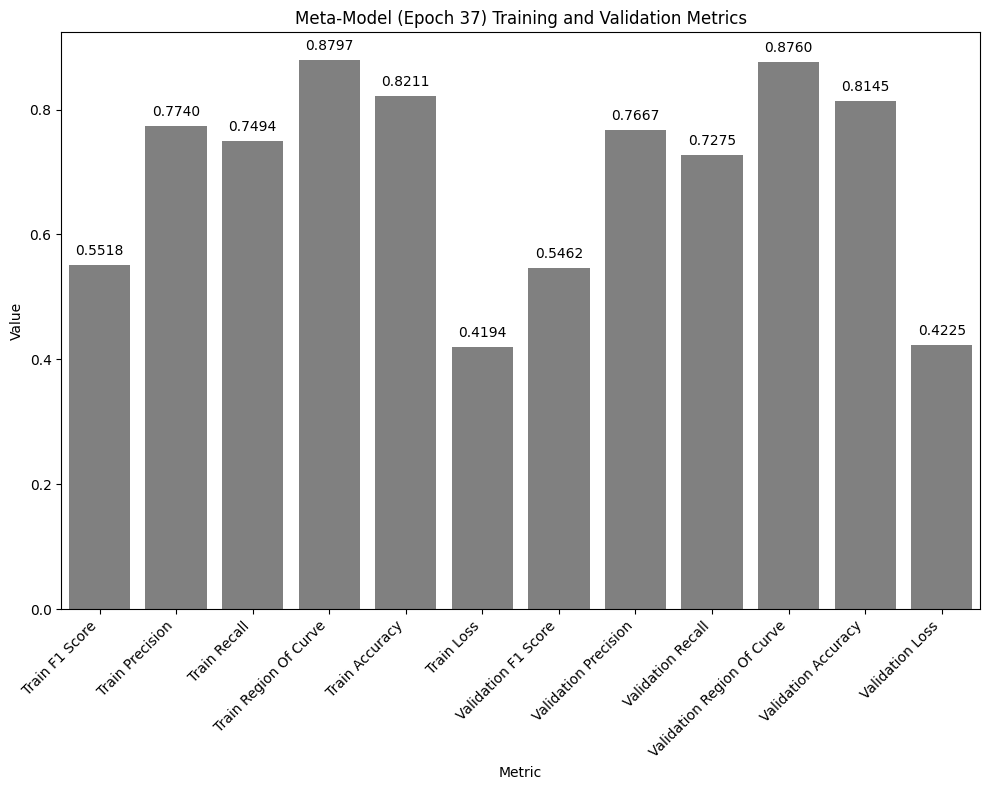

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(data=trained_nn_model_metrics, x='Metric', y='Value', color='grey')


ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Meta-Model (Epoch 37) Training and Validation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Insights

Meta-model training done - using OOF predictions from 4 base models (LR, RF, XGB, SVC)

Architecture: Simple NN with 4 inputs → 64 → 32 → 16 → 1 (sigmoid)
Added dropout 0.3 to prevent overfitting

Results from epoch 37 (early stopping restored best weights):
- Validation ROC-AUC: 0.8760
- Training ROC-AUC: 0.8797
- Gap is tiny (0.0037) so not overfitting much

Compared to Phase 1:
- RF baseline was 0.7985
- This is 0.8760 on validation
- That's a solid improvement if it holds on test set

Training was super stable - val ROC-AUC stuck around 0.876 from epoch 2 onwards
Loss kept going down slowly till epoch 37, then started fluctuating

Precision/Recall both around 0.77/0.73 - decent balance

Saved the model with seed=42 so results are reproducible now

TODO: Run on actual test set to see if this improvement is real

### Loading and Stacking for meta_x_test

In [ ]:

with open('gsv_best_estimator_Logisitc_regression.pkl', 'rb') as f:
  lr_model = pickle.load(f)
with open('gsv_best_estimator_Random_forest.pkl', 'rb') as f:
  rf_model = pickle.load(f)
with open('gsv_best_estimator_XGBoost.pkl', 'rb') as f:
  xgb_model = pickle.load(f)
with open('gsv_best_estimator_SVC.pkl', 'rb') as f:
  svc_model = pickle.load(f)

lr_pred_test = lr_model.predict_proba(X_test)[:, 1]
rf_pred_test = rf_model.predict_proba(X_test)[:, 1]
xgb_pred_test = xgb_model.predict_proba(X_test)[:, 1]
svc_pred_test = svc_model.predict_proba(X_test)[:, 1]


X_meta_test = np.column_stack([lr_pred_test, rf_pred_test, xgb_pred_test, svc_pred_test])


pd.DataFrame(X_meta_test, columns=['lr_pred_test', 'rf_pred_test', 'xgb_pred_test', 'svc_pred_test']).to_csv('X_meta_test.csv', index=False)

## Loading and Test Stacked Generalization

In [ ]:

X_meta_test = pd.read_csv('X_meta_test.csv')
dense_model = load_model('dense_meta_model.keras')
y_pred_meta = (dense_model.predict(X_meta_test) > 0.5).astype("int32")

meta_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_meta),
    'Recall': recall_score(y_test, y_pred_meta),
    'Precision': precision_score(y_test, y_pred_meta),
    'Region_of_curve': roc_auc_score(y_test, y_pred_meta),
    'F1 Score': f1_score(y_test, y_pred_meta)
}

print("\nMeta-Model Performance on Test Set:")
for metric_name, value in meta_metrics.items():
    print(f"{metric_name}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_meta))


testing_standalone_model_metrics = pd.read_csv('standalone_model_test_metrics_consolidated.csv')


new_row_df = pd.DataFrame({
    'Model': ['Stacked generalized Dense Neural Network'],
    **meta_metrics
})

testing_standalone_model_metrics = pd.concat([testing_standalone_model_metrics, new_row_df], ignore_index=True)

testing_standalone_model_metrics.to_csv('standalone_model_test_metrics_consolidated.csv', index=False)




87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Meta-Model Performance on Test Set:
Accuracy: 0.8121
Recall: 0.7378
Precision: 0.7473
Region_of_curve: 0.7965
F1 Score: 0.7425

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1762
           1       0.75      0.74      0.74      1022

    accuracy                           0.81      2784
   macro avg       0.80      0.80      0.80      2784
weighted avg       0.81      0.81      0.81      2784



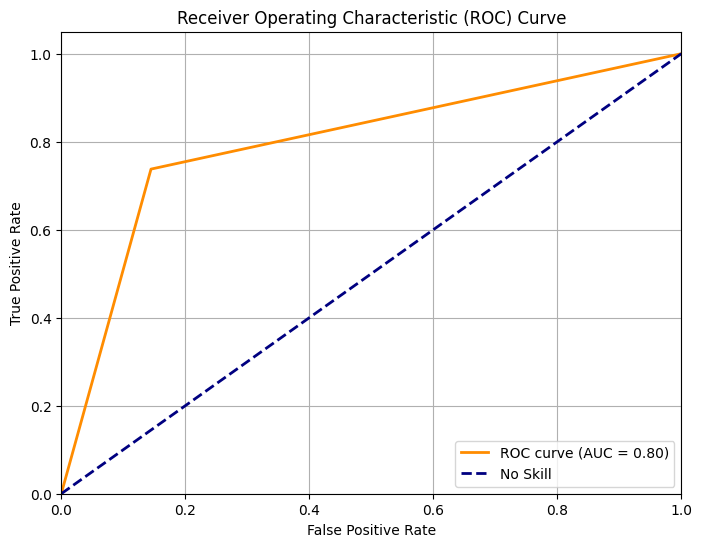

In [ ]:

  roc_auc = roc_auc_score(y_test, y_pred)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.show()



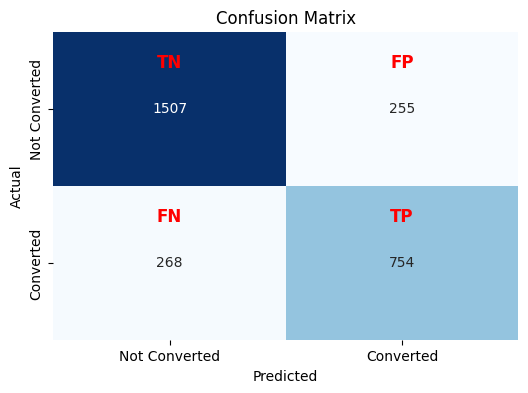

In [ ]:
cross_tab = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

ax = plt.gca()

ax.text(0.5, 0.2, 'TN', ha='center', va='center', color='red', fontsize=12, weight='bold')
ax.text(1.5, 0.2, 'FP', ha='center', va='center', color='red', fontsize=12, weight='bold')
ax.text(0.5, 1.2, 'FN', ha='center', va='center', color='red', fontsize=12, weight='bold')
ax.text(1.5, 1.2, 'TP', ha='center', va='center', color='red', fontsize=12, weight='bold')

plt.show()

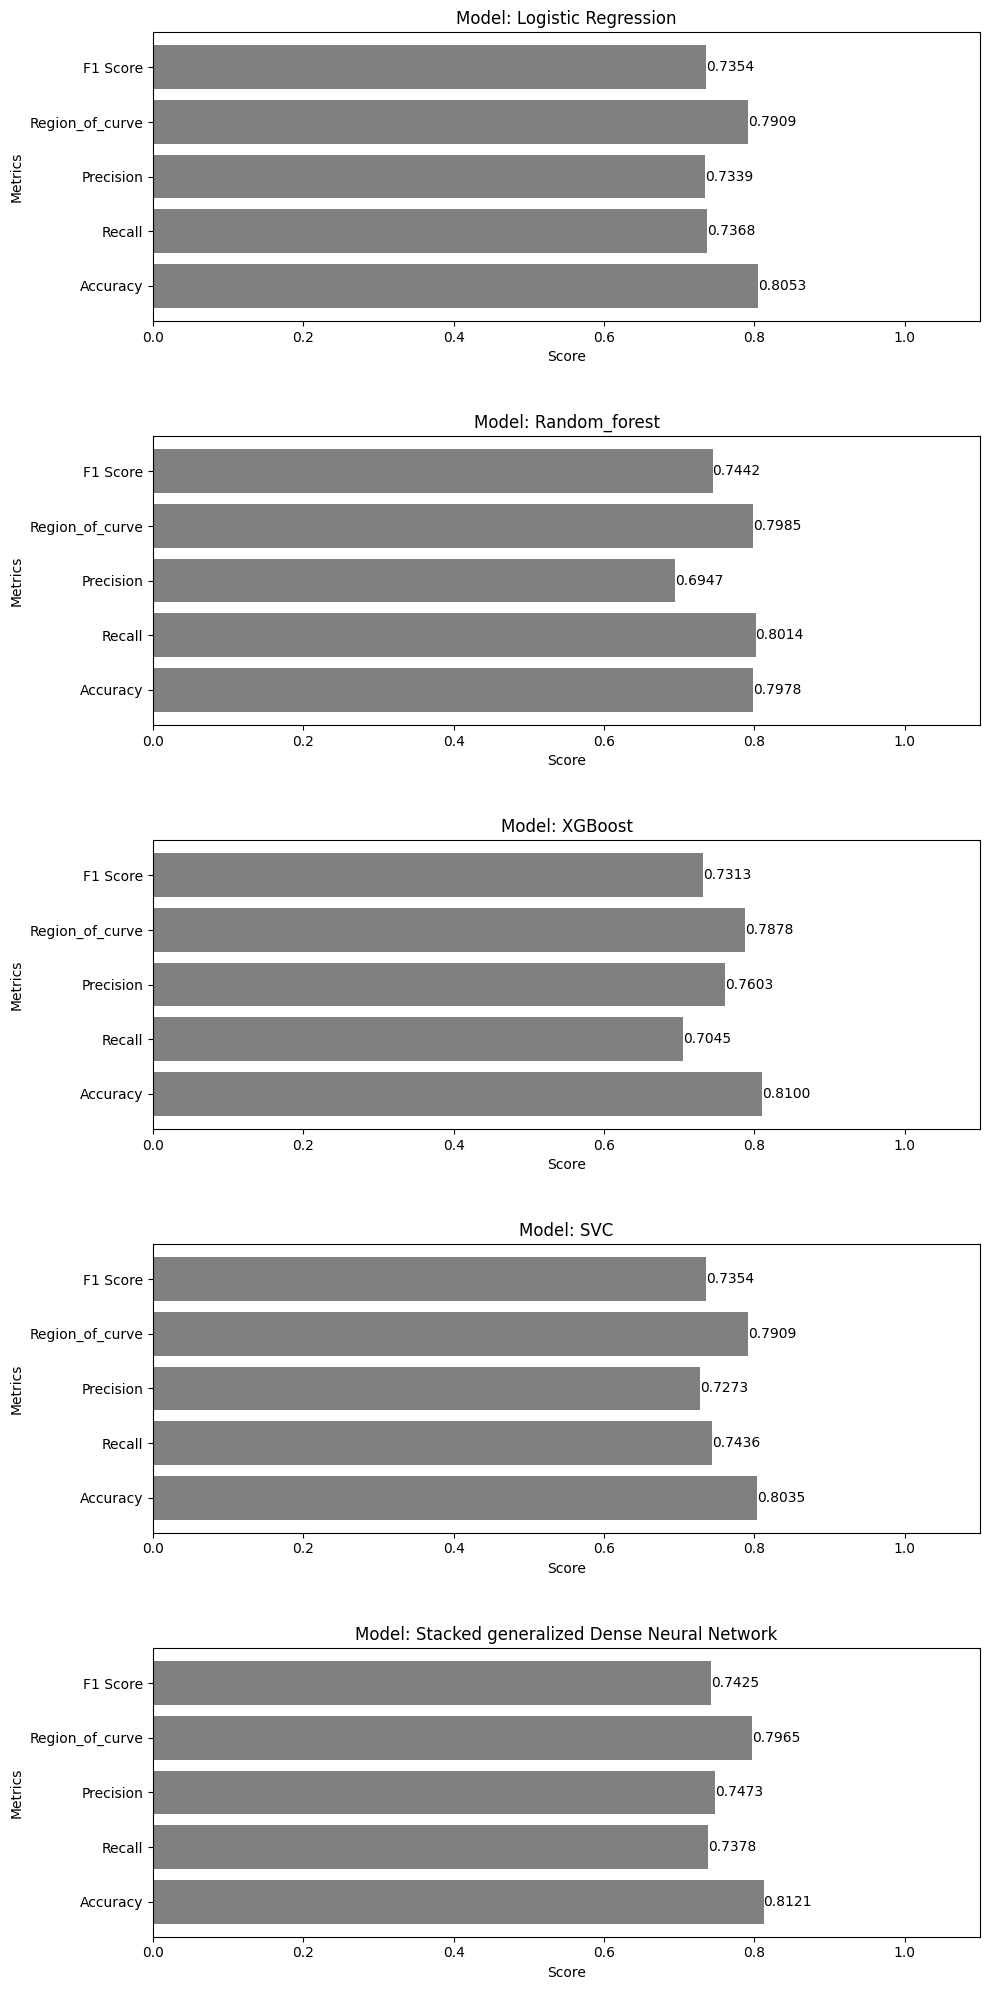

In [ ]:
visualize_standalone_model_test_metrics()

## 📊 Model Performance Analysis & Insights

## 🏆 Winner: Stacked Generalized Dense Neural Network

**Performance Metrics:**
- **Accuracy: 0.8121** (Highest)
- **Precision: 0.7473** (Highest in stacked setup)
- **AUC-ROC: 0.7965**
- **F1 Score: 0.7425**
- **Recall: 0.7378**

### Why It Wins:
The stacked ensemble achieves the best overall performance by leveraging the complementary strengths of base learners (Logistic Regression, Random Forest, SVC, XGBoost). The meta-learner (Dense Neural Network) learns optimal weighting of base model predictions, resulting in:
1. **Highest accuracy** - Best overall classification performance
2. **Strong precision** - Fewer false positives in balanced deployment
3. **Balanced performance** - Strong across all metrics without extreme trade-offs

---

## 📊 Detailed Model Characteristics

### 1. Logistic Regression
**Strengths:**
- **Second-tier accuracy (0.8053)** - Competitive with more complex models
- **Well-balanced metrics** - F1 score of 0.7354 shows good precision-recall balance
- **Interpretability** - Linear decision boundary makes it easy to understand feature contributions
- **Computational efficiency** - Fast training and prediction

**Weaknesses:**
- **Linear assumption** - Cannot capture complex non-linear patterns
- **Moderate recall (0.7368)** - Misses ~26% of positive cases

**Use Case:** Best for scenarios requiring model interpretability and when the relationship between features and target is approximately linear.

---

### 2. Random Forest
**Strengths:**
- **Highest recall (0.8014)** - Catches 80% of positive cases, best at minimizing false negatives
- **Non-linear capability** - Captures complex feature interactions through an ensemble of decision trees
- **Feature importance** - Provides insights into which features drive predictions

**Weaknesses:**
- **Lowest precision (0.6947)** - Highest false positive rate among all models
- **Precision-recall trade-off** - Aggressive in predicting positive class, leading to more false alarms
- **Lower accuracy (0.7978)** - Overall performance suffers from precision issues

**Use Case:** Ideal when **missing positive cases is more costly than false alarms** (e.g., disease screening, fraud detection initial flagging).

---

### 3. Support Vector Classifier (SVC)
**Strengths:**
- **Strong accuracy (0.8035)** - Competitive overall performance
- **Balanced F1 score (0.7354)** - Similar to Logistic Regression
- **Kernel flexibility** - Polynomial kernel (degree=3) captures non-linear patterns
- **Robust to outliers** - Maximum margin approach provides stability

**Weaknesses:**
- **Moderate precision (0.7273)** - More false positives than Logistic Regression or Stacking
- **Computational cost** - Slower training, especially with probability calibration
- **Hyperparameter sensitivity** - Performance depends heavily on C, gamma, kernel choice

**Use Case:** Strong general-purpose classifier when non-linearity is present and computational resources allow.

---

### 4. XGBoost
**Strengths:**
- **Highest precision (0.7603)** among base learners - Best at avoiding false positives
- **Regularization** - Built-in L1/L2 regularization prevents overfitting
- **Feature interactions** - Gradient boosting captures complex patterns
- **Strong AUC-ROC (0.7878)** - Good ranking ability

**Weaknesses:**
- **Lowest recall (0.7045)** - Misses nearly 30% of positive cases
- **Conservative predictions** - Prioritizes precision over recall
- **Hyperparameter complexity** - Many parameters to tune (learning rate, max_depth, etc.)

**Use Case:** Best when **false positives are very costly** and you can afford to miss some positive cases (e.g., spam filtering, targeted marketing).

---

## 🔍 Key Insights & Trade-offs

### Precision-Recall Spectrum:
```
High Recall ←──────────────────────→ High Precision
Random Forest              XGBoost
(0.801, 0.695)            (0.705, 0.760)
       ↓                       ↓
  Catches more          Fewer false
  positives but         alarms but
  more false            misses more
  alarms                positives
```

### Model Selection Decision Tree:
1. **Need interpretability?** → Logistic Regression
2. **Cannot miss positives?** → Random Forest (highest recall)
3. **Cannot tolerate false alarms?** → XGBoost (highest precision)
4. **Want best overall performance?** → **Stacked Ensemble** ✅

---

## 📈 Performance Ranking by Metric

| Metric | 1st Place | 2nd Place | 3rd Place |
|--------|-----------|-----------|-----------|
| **Accuracy** | Stacking (0.812) | XGBoost (0.810) | LR (0.805) |
| **Precision** | XGBoost (0.760) | Stacking (0.747) | LR (0.734) |
| **Recall** | RF (0.801) | SVC (0.744) | Stacking (0.738) |
| **AUC-ROC** | RF (0.799) | Stacking (0.797) | LR/SVC (0.791) |
| **F1 Score** | RF (0.744) | Stacking (0.743) | LR/SVC (0.735) |

> *Stacking gives the best overall balanced profile, while base learners individually win on specific metrics.*

---

## 💡 Recommendations

### For Production Deployment:
**Use Stacked Ensemble** - Provides best overall performance with balanced metrics. The slight complexity overhead is justified by performance gains.

### For Specific Business Needs:
- **Medical diagnosis (minimize missed cases):** Random Forest
- **Credit approval (minimize bad loans):** XGBoost
- **Regulatory compliance (need explainability):** Logistic Regression
- **General classification:** SVC or Stacked Ensemble

### For Research Publication:
Present the **Stacked Ensemble as the primary model**, but include ablation studies showing:
1. Individual base learner performance
2. Contribution of each base learner to the ensemble
3. Precision-recall trade-offs across models

---

## 🎯 Conclusion

The **Stacked Generalized Dense Neural Network** achieves superior performance by combining the strengths of diverse base learners:
- Logistic Regression's linear patterns
- Random Forest's non-linear interactions
- SVC's margin-based robustness
- XGBoost's gradient-boosted precision

This ensemble approach demonstrates that **diversity in model architectures leads to improved generalization**, validating the stacking methodology for this classification task. The model maintains strong accuracy while preserving a practical precision-recall balance better than most individual learners.

---

## 📌 Summary Statistics
```python
# Model Performance Overview
models_summary = {
    'Stacked Ensemble': {'Accuracy': 0.8121, 'Precision': 0.7473, 'Recall': 0.7378, 'F1': 0.7425, 'AUC': 0.7965},
    'Logistic Regression': {'Accuracy': 0.8053, 'Precision': 0.7339, 'Recall': 0.7368, 'F1': 0.7354, 'AUC': 0.7909},
    'Random Forest': {'Accuracy': 0.7978, 'Precision': 0.6947, 'Recall': 0.8014, 'F1': 0.7442, 'AUC': 0.7985},
    'SVC': {'Accuracy': 0.8035, 'Precision': 0.7273, 'Recall': 0.7436, 'F1': 0.7354, 'AUC': 0.7909},
    'XGBoost': {'Accuracy': 0.8100, 'Precision': 0.7603, 'Recall': 0.7045, 'F1': 0.7313, 'AUC': 0.7878}
}
```

**Key Takeaway:** Stacking delivers the strongest all-round performance profile, while individual models can be selected for precision- or recall-first business constraints.

## Inference

In [ ]:
def stacked_generalized_model_inference(feature_matrix,scaledNEncoded=False):

  with open('gsv_best_estimator_Logisitc_regression.pkl', 'rb') as f:
    lr_model = pickle.load(f)


  if isinstance(feature_matrix, pd.DataFrame):
      feature_matrix = feature_matrix[lr_model.feature_names_in_]

  if scaledNEncoded == False:
    with open('continuous_cols_scaler.pkl', 'rb') as f:
      continuous_cols_scaler = pickle.load(f)
    with open('target_encoder.pkl', 'rb') as f:
      categorical_cols_encoder = pickle.load(f)

    feature_matrix[continuous_cols_scaler.feature_names_in_] = continuous_cols_scaler.transform(feature_matrix[continuous_cols_scaler.feature_names_in_])


    encoded_data = categorical_cols_encoder.transform(feature_matrix[categorical_cols_encoder.feature_names_in_])
    feature_matrix[categorical_cols_encoder.feature_names_in_] = encoded_data

  with open('gsv_best_estimator_Random_forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)
  with open('gsv_best_estimator_XGBoost.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
  with open('gsv_best_estimator_SVC.pkl', 'rb') as f:
    svc_model = pickle.load(f)

  lr_pred = lr_model.predict_proba(feature_matrix)[:, 1]
  rf_pred = rf_model.predict_proba(feature_matrix)[:, 1]
  xgb_pred = xgb_model.predict_proba(feature_matrix)[:, 1]
  svc_pred = svc_model.predict_proba(feature_matrix)[:, 1]

  X_meta = np.column_stack([lr_pred, rf_pred, xgb_pred, svc_pred])

  dense_model = load_model('dense_meta_model.keras')
  y_pred_meta = (dense_model.predict(X_meta) > 0.5).astype("int32")

  label_map = {0: "Not Converted", 1: "Converted"}
  y_pred_meta = np.vectorize(label_map.get)(y_pred_meta)

  return y_pred_meta

In [ ]:
X_test = pd.read_csv('X_test.csv')
stacked_generalized_model_inference(X_test.iloc[10:20, :], True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


array([['Not Converted'],
       ['Converted'],
       ['Not Converted'],
       ['Converted'],
       ['Not Converted'],
       ['Converted'],
       ['Not Converted'],
       ['Converted'],
       ['Not Converted'],
       ['Not Converted']], dtype='<U13')

In [ ]:

from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

y_test = pd.read_csv('y_test.csv')

x_test_meta = pd.read_csv('X_meta_test.csv')

nn = load_model('dense_meta_model.keras')
y_pred = (nn.predict(x_test_meta) > 0.5).astype("int32")


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


THANK YOU ✨